# Analysis of speed limit induced CO2 reduction within real-world motorway networks

In [1]:
import networkx as nx
import osmnx as ox
import requests
import pandas as pd
import numpy as np
import math
import sys
import json

from dateutil.parser import parse
import datetime
from os import listdir
from os.path import isfile, join

import matplotlib.cm as cm
import matplotlib.colors as colors
import matplotlib.patches as mpatches
import matplotlib.pyplot as plt
%matplotlib inline
ox.config(use_cache=True, log_console=True)
ox.__version__

'0.15.0'

## Research Question: "To what extent can speed limits on motorways contribute to CO2 reductions?"

# ------------------------------------------------------------------------------

# Custom Plotting Logic & Helper Functions

# ------------------------------------------------------------------------------

In [2]:
def get_colors(n, cmap="viridis", start=0.0, stop=1.0, alpha=1.0, return_hex=False):
    """
    Get n evenly-spaced colors from a matplotlib colormap.
    Parameters
    ----------
    n : int
        number of colors
    cmap : string
        name of a matplotlib colormap
    start : float
        where to start in the colorspace
    stop : float
        where to end in the colorspace
    alpha : float
        opacity, the alpha channel for the RGBa colors
    return_hex : bool
        if True, convert RGBa colors to HTML-like hexadecimal RGB strings. if
        False, return colors as (R, G, B, alpha) tuples.
    Returns
    -------
    color_list : list
    """
    color_list = [cm.get_cmap(cmap)(x) for x in np.linspace(start, stop, n)]
    if return_hex:
        color_list = [colors.to_hex(c) for c in color_list]
    else:
        color_list = [(r, g, b, alpha) for r, g, b, _ in color_list]
    return color_list

In [3]:
def _get_colors_by_value(vals, num_bins, cmap, start, stop, na_color, equal_size):
    """
    Map colors to the values in a series.
    Parameters
    ----------
    vals : pandas.Series
        series labels are node/edge IDs and values are attribute values
    num_bins : int
        if None, linearly map a color to each value. otherwise, assign values
        to this many bins then assign a color to each bin.
    cmap : string
        name of a matplotlib colormap
    start : float
        where to start in the colorspace
    stop : float
        where to end in the colorspace
    na_color : string
        what color to assign to missing values
    equal_size : bool
        ignored if num_bins is None. if True, bin into equal-sized quantiles
        (requires unique bin edges). if False, bin into equal-spaced bins.
    Returns
    -------
    color_series : pandas.Series
        series labels are node/edge IDs and values are colors
    """
    if len(vals) == 0:
        raise ValueError("There are no attribute values.")

    if num_bins is None:
        # calculate min/max values based on start/stop and data range
        vals_min = vals.dropna().min()
        vals_max = vals.dropna().max()
        full_range = (vals_max - vals_min) / (stop - start)
        full_min = vals_min - full_range * start
        full_max = full_min + full_range

        # linearly map a color to each attribute value
        normalizer = colors.Normalize(full_min, full_max)
        scalar_mapper = cm.ScalarMappable(normalizer, cm.get_cmap(cmap))
        color_series = vals.map(scalar_mapper.to_rgba)
        color_series.loc[pd.isnull(vals)] = na_color

    else:
        # otherwise, bin values then assign colors to bins
        cut_func = pd.qcut if equal_size else pd.cut
        bins, intervals = cut_func(vals, num_bins, labels=range(num_bins), retbins=True)
        bin_colors = get_colors(num_bins, cmap, start, stop)
        color_list = [bin_colors[b] if pd.notnull(b) else na_color for b in bins]
        color_series = pd.Series(color_list, index=bins.index)

    return color_series, bin_colors, intervals

In [4]:
def get_edge_colors_by_TomTom_Attribute(G, requestedTime="16:00", requestedAttribute="travelSpeed",num_bins=None, cmap="viridis", start=0, stop=1, na_color="none", equal_size=False):

    out = {}
    
    edge_info = {k:v for k,v in nx.get_edge_attributes(G, "tomtomData").items()}
    for edge, data in edge_info.items():
        if not bool(data):
            out.update({edge: None})
        else:
            if requestedTime in data:
                out.update({edge: data[requestedTime][requestedAttribute]})
            else:
                out.update({edge: None})

    vals = pd.Series(out)
    return _get_colors_by_value(vals,num_bins, cmap, start, stop, na_color, equal_size)

In [5]:
def plotRelevantEdges(edgeList):
    ec = ['r' if edge in edgeList else 'darkblue' for edge in G.edges()]
    #fig, ax = ox.plot_graph(G, edge_color=ec, edge_linewidth=1, node_size=0, figsize=(12,12), bgcolor = "#061529")
    fig, ax = ox.plot_graph(G, edge_color=ec, edge_linewidth=1, node_size=0, figsize=(12,12), bgcolor = "white")

def plotRelevantNodes(nodeList):
    nc = ['r' if node in nodeList else 'none' for node in G.nodes()]
    fig, ax = ox.plot_graph(G, node_color=nc, edge_linewidth=1, edge_color="black", node_size=20, figsize=(12,12), bgcolor = "white")

In [6]:
def get_edge_TomTom_Attribute(requestedTime="16:00", requestedAttribute="travelSpeed"):

    out = {}
    
    edge_info = {k:v for k,v in nx.get_edge_attributes(G, "tomtomData").items()}
    for edge, data in edge_info.items():
        if not bool(data):
            out.update({edge: None})
        else:
            if requestedTime in data:
                out.update({edge: data[requestedTime][requestedAttribute]})
            else:
                out.update({edge: None})
    
    return out

In [7]:
def getSpeedLimitFromList(l):
    int_speeds = []
    for val in l:
        if val != "none" and val != "signals":
            int_speeds.append(int(val))

    if len(int_speeds) > 0:
        speedlimit = max(int_speeds)
    else:
        return 10000
    
    return speedlimit

In [8]:
def round_time(dt=None, round_to=1800):
    if dt == None: 
        dt = datetime.datetime.now()
    dt = dt.replace(tzinfo=None)
    seconds = (dt - dt.min).seconds
    rounding = (seconds+round_to/2) // round_to * round_to
    new_dt = dt + datetime.timedelta(0,rounding-seconds,-dt.microsecond)
    return '%i:%02i' % (new_dt.hour, new_dt.minute)

# ------------------------------------------------------------------------------

# Network manipulation methodology

# ------------------------------------------------------------------------------

# Step 1: Retrieve Network as graph from Open Street Maps

In [9]:
# get a graph for some city
# G = ox.graph_from_place('Bavaria, Germany', custom_filter=f'["highway"]["area"!~"yes"]["highway"~"motorway"]')
# fig, ax = ox.plot_graph(G)

In [10]:
# save graph to disk as geopackage (for GIS) or graphml file (for gephi etc)
# ox.save_graph_geopackage(G, filepath='./data/bavaria_highways.gpkg')
# ox.save_graphml(G, filepath='./data/bavaria_highways.graphml')

### Alternative Step 1: Load network from file

In [11]:
# load already prepared network from file to save time
G = nx.read_gpickle("data/germany_supplemented.pkl")

In [22]:
#G = ox.load_graphml(filepath='./data/germany_highways.graphml')

# Step 2: Import traffic count data from the Bundesanstalt für Straßenwesen (BASt)

In [33]:
# load data
df_verkehr = pd.read_csv("./data/verkehrszaehlung2018_komplett.csv", sep=";", encoding = "ISO-8859-1", decimal=",")

# filter data
df_verkehr = df_verkehr[df_verkehr["Str_Kl"] == "A"]

In [34]:
# adjust format for coordinates
df_verkehr["latitude"] = df_verkehr["Koor_WGS84_N"].apply(lambda x: float(x))
df_verkehr["longitude"] = df_verkehr["Koor_WGS84_E"].apply(lambda x: float(x))

In [35]:
# fix formatting issues with numeric values (datasets contain stupid formatting like 5.357.432 instead of 5357432.00)
df_verkehr["DTV_Kfz_MobisSo_Q"] = df_verkehr["DTV_Kfz_MobisSo_Q"].apply(lambda x: float(str(x).replace(".", "")))
df_verkehr["DTV_SV_MobisSo_Q"] = df_verkehr["DTV_SV_MobisSo_Q"].apply(lambda x: float(str(x).replace(".", "")))

In [36]:
# remove rows with NA values
df_verkehr = df_verkehr[df_verkehr['DTV_Kfz_MobisSo_Q'].notna()]

# Step 3: Map traffic count information onto network nodes (with 5km max radius)

In [37]:
# set default values for every edge (initialize) which are later overwritten for relevant edges
nx.set_node_attributes(G, "", "roadname")
nx.set_node_attributes(G, 0, "quantity_cars")
nx.set_node_attributes(G, 0, "quantity_trucks")
nx.set_node_attributes(G, "", "general_direction")
nx.set_node_attributes(G, "", "current_location")

counter = 0
total = 0
nodes_with_data = []
for idx, row in df_verkehr.iterrows():
    lat, lng = row["latitude"], row["longitude"]
    node, dist = ox.get_nearest_node(G, (lat,lng), return_dist=True)
    total += 1
    
    if dist < 5000:
        counter += 1
        nodes_with_data.append(node)
        
        G.nodes[node]["roadname"] = row["Str_Kl"] + str(row["Str_Nr"])
        G.nodes[node]["quantity_cars"] = row["DTV_Kfz_MobisSo_Q"] / 2 # every row in dataframe contains data for both directions --> split in half for one-directional data
        G.nodes[node]["quantity_trucks"] = row["DTV_SV_MobisSo_Q"] / 2
        G.nodes[node]["general_direction"] = row["Fernziel_Ri1"]
        G.nodes[node]["current_location"] = row["Nahziel_Ri2"]

C:\Users\pasca\Anaconda3\envs\ox\lib\site-packages\osmnx\utils_graph.py:56: FutureWarning: Assigning CRS to a GeoDataFrame without a geometry column is now deprecated and will not be supported in the future.
  gdf_nodes = gpd.GeoDataFrame(data, index=nodes, crs=crs)


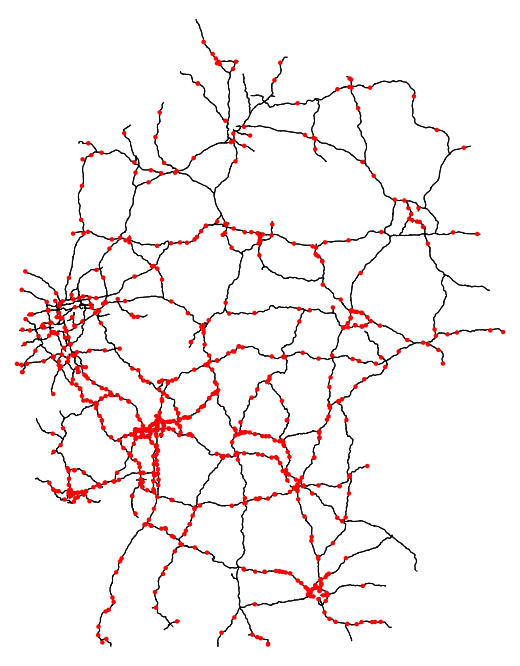

In [45]:
# visualize nodes which now have traffic count information
plotRelevantNodes(nodes_with_data)

# Step 4: Supplement nodes that are not directly counted via BASt traffic count

For every node that has no traffic data yet, we use a nearest node search by aerial distance to identify the closest node which has traffic information on it

In [46]:
nodes_without_data = [n for n in G.nodes() if G.nodes[n]["quantity_cars"] == 0]
nodes_without_data_coords = [(G.nodes[n]["y"], G.nodes[n]["y"]) for n in G.nodes() if G.nodes[n]["quantity_cars"] == 0]

nodes_with_data_coords = [(G.nodes[n]["y"], G.nodes[n]["y"]) for n in nodes_with_data]

In [47]:
nodes_with_assigned_data = [n for n in G.nodes() if G.nodes[n]["quantity_cars"] > 0]
nodes_with_na_data = [n for n in G.nodes() if G.nodes[n]["quantity_cars"] ]

In [48]:
diff_nodes = set(G.nodes()).difference(set(nodes_with_assigned_data))

In [49]:
for orig_idx, orig_node in enumerate(nodes_without_data_coords):
    nearest_node = 0
    nn_dist = 100000
    for dest_idx, dest_node in enumerate(nodes_with_data_coords):
        dist = ox.distance.great_circle_vec(*orig_node, *dest_node)
        if dist < nn_dist:
            nearest_node = nodes_with_data[dest_idx]
            nn_dist = dist
    
    orig_nodeID = nodes_without_data[orig_idx]
    G.nodes[orig_nodeID]["quantity_cars"] = G.nodes[nearest_node]["quantity_cars"]

In [50]:
nodes_without_data = [n for n in G.nodes() if G.nodes[n]["quantity_cars"] == 0]
nodes_without_data_coords = [(G.nodes[n]["y"], G.nodes[n]["y"]) for n in G.nodes() if G.nodes[n]["quantity_cars"] == 0]

nodes_with_data_coords = [(G.nodes[n]["y"], G.nodes[n]["y"]) for n in nodes_with_data]

# Step 5: Assign traffic count data to network edges

In [51]:
# traffic count on edge is calculated by taking the average of both defining nodes
nx.set_edge_attributes(G, 0, "quantity_cars")

for e in G.edges():
    n1, n2 = e
    qcars1, qcars2 = G.nodes[n1]["quantity_cars"], G.nodes[n2]["quantity_cars"]
    avg_qcars = (qcars1 + qcars2) / 2
    G.edges[(*e, 0)]["quantity_cars"] = avg_qcars

## Intermediate result 1: Network containing traffic count information

Network colored by quantity of cars per edge per day


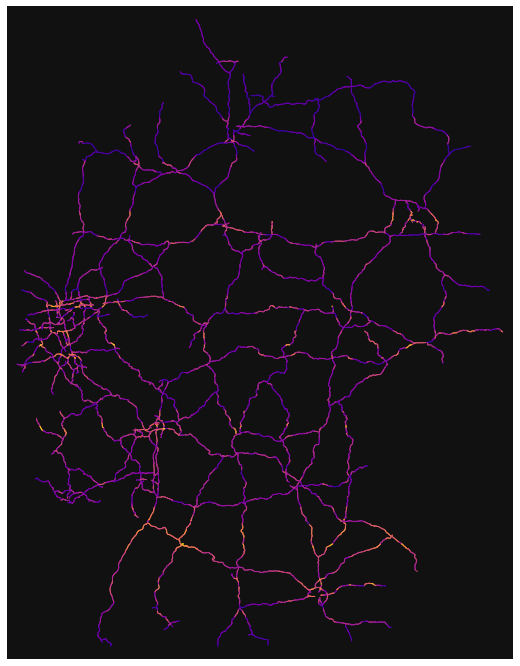

In [54]:
print("Network colored by quantity of cars per edge per day")
ec = ox.plot.get_edge_colors_by_attr(G, attr='quantity_cars', cmap='plasma', na_color="red", equal_size=True)
fig, ax = ox.plot_graph(G, edge_color=ec, edge_linewidth=1, node_size=0, figsize=(12,12))
#fig.savefig("test.png", dpi=1000)

# Step 6: Identify Motorway End Nodes in Network

In [55]:
endpoints = []
for n in G.nodes():
    motorways = 0
    for e in G.out_edges(n):
        if G.out_edges[(*e, 0)]["highway"] == "motorway":
            motorways += 1
    for e in G.in_edges(n):
        if G.in_edges[(*e, 0)]["highway"] == "motorway":
            motorways += 1
    
    if motorways == 1:
        endpoints.append(n)

# Step 7: Identify central network node via degree centrality

In [57]:
node_centralities = {k: v for k, v in sorted(nx.degree_centrality(G).items(), key=lambda item: item[1], reverse=True)}
central_node = next(iter(node_centralities))

# Step 8: Calculate shortest paths via Dijsktra Algorithm from central node to all end nodes

In [58]:
routes = []
failed = []
for n in endpoints:
    try:
        routes.append(nx.algorithms.shortest_path(G, source=central_node, target=n, weight="length"))
    except:
        failed.append(n)
        continue

In [59]:
#### Plot all retrieved routes

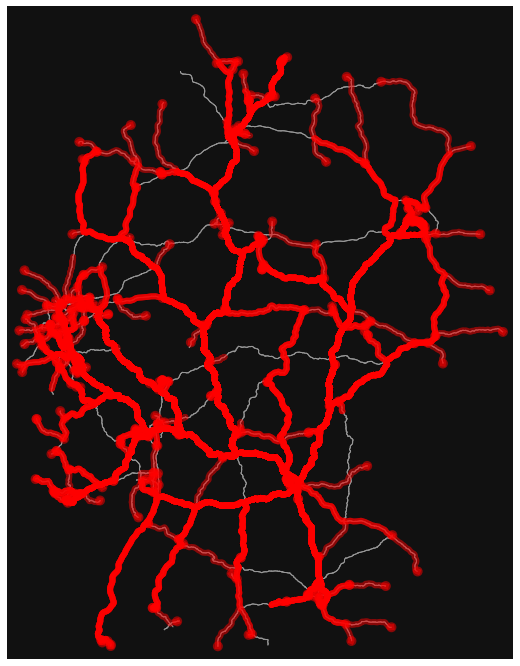

In [60]:
fig, ax = ox.plot_graph_routes(G, routes=routes,
                               route_linewidth=6, node_size=0, figsize=(12,12))

# Step 9: Identify all end nodes that are not part of the shortest paths from Step 8

# Step 10: Calculate shortest paths via Dijsktra Algorithm from remaining end nodes to central node

In [61]:
remaining_routes = []
still_fail = []
for n in failed:
    try:
        remaining_routes.append(nx.algorithms.shortest_path(G, source=n, target=central_node, weight="length"))
    except:
        still_fail.append(n)
        continue

# Step 11: Combining retrieved paths from step 8 and 10

In [62]:
all_routes = routes + remaining_routes

# Step 12: Identify all nodes currently not visited by routing logic

In [63]:
flattened_list = [y for x in all_routes for y in x]

In [64]:
# makes no sense --> observation: routes only connect via motorway_link nodes
nodes_in_routes = set(flattened_list)

nodes_in_routes_nolinks = []
for n in nodes_in_routes:
    motorways = 0
    for e in G.out_edges(n):
        if G.out_edges[(*e, 0)]["highway"] == "motorway":
            motorways += 1
    for e in G.in_edges(n):
        if G.in_edges[(*e, 0)]["highway"] == "motorway":
            motorways += 1
    
    if motorways > 0:
        nodes_in_routes_nolinks.append(n)

In [65]:
relevant_nodes = [] # relevant is every node which has a connection to a motorway
for n in G.nodes():
    motorways = 0
    for e in G.out_edges(n):
        if G.out_edges[(*e, 0)]["highway"] == "motorway":
            motorways += 1
    for e in G.in_edges(n):
        if G.in_edges[(*e, 0)]["highway"] == "motorway":
            motorways += 1
    
    if motorways > 0:
        relevant_nodes.append(n)

In [66]:
currently_not_used = set(relevant_nodes).difference(nodes_in_routes_nolinks); print(len(currently_not_used))

3630


# Step 13: Identify new start and end points within currently missing nodes

In [68]:
# identify end points
new_endpoints = []
for node in currently_not_used: # check all nodes that are not currently on any route
    
    for e in G.out_edges(node): # check all edges of current node
        n1, n2 = e # unpack both nodes of edge (start, end)
        if n1 == node: # we only need to check edge node that is not our currentNode
            currentOtherNode = n2
        else:
            currentOtherNode = n1
        
        if currentOtherNode in nodes_in_routes_nolinks: # if we find an opposing edge node that is already in a route, we identified a new endpoint
            new_endpoints.append(currentOtherNode)

In [69]:
# identify end points
new_startpoints = []
for node in currently_not_used: # check all nodes that are not currently on any route
    
    for e in G.in_edges(node): # check all edges of current node
        n1, n2 = e # unpack both nodes of edge (start, end)
        if n1 == node: # we only need to check edge node that is not our currentNode
            currentOtherNode = n2
        else:
            currentOtherNode = n1
        
        if currentOtherNode in nodes_in_routes_nolinks: # if we find an opposing edge node that is already in a route, we identified a new endpoint
            new_startpoints.append(currentOtherNode)

# Step 14: Building paths between missing start and end points

In [70]:
# follow along an edge node by noode to identify endpoint
# endpoint is a point that is either already in previous routes or in newly identified endpoints
def recursiveEdges(node):
    for e in G.out_edges(node):
            if G.edges[(*e, 0)]["highway"] == "motorway":
                n1, currentNode = e
                
                if currentNode in new_endpoints or currentNode in nodes_in_routes_nolinks:
                    return currentNode
                else:
                    if currentNode in currently_not_used:
                        return recursiveEdges(currentNode)

In [71]:
missing_endpoints = {}
fail_nodes = []
for node in new_startpoints:
    if recursiveEdges(node) == None:
        fail_nodes.append(node)
    else:
        missing_endpoints[node] = recursiveEdges(node)

In [72]:
missing_routes = []
for k, v in missing_endpoints.items():
    missing_routes.append(nx.shortest_path(G, source = k, target = v, weight = "length"))

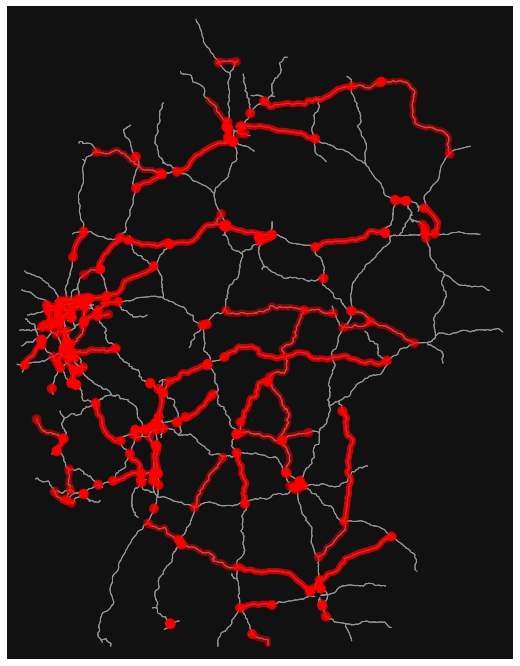

In [73]:
fig, ax = ox.plot_graph_routes(G, routes=missing_routes,
                               route_linewidth=6, node_size=0, figsize=(12,12))

# Step 15: Combining paths from steps 11 and 14

In [74]:
all_relevant_paths = all_routes + missing_routes

In [75]:
nx.set_edge_attributes(G, 0, "visited")
for route in all_relevant_paths:
    for i in range(len(route) - 1):
        G.edges[(route[i], route[i+1], 0)]["visited"] = 1
        

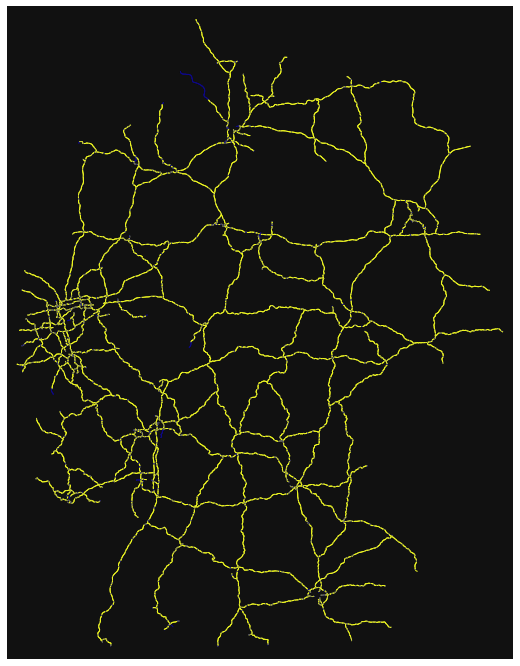

In [76]:
ec = ox.plot.get_edge_colors_by_attr(G, attr='visited', cmap='plasma', na_color="red")
fig, ax = ox.plot_graph(G, edge_color=ec, edge_linewidth=1, node_size=0, figsize=(12,12))
#fig.savefig("test.png", dpi=1000)

In [77]:
# makes no sense --> observation: routes only connect via motorway_link nodes
flattened_list = [y for x in all_relevant_paths for y in x]
nodes_in_routes = set(flattened_list); print("Nodes in current routes (incl. Motorway Links): ", len(nodes_in_routes))

nodes_in_routes_nolinks = []
for n in nodes_in_routes:
    motorways = 0
    for e in G.out_edges(n):
        if G.out_edges[(*e, 0)]["highway"] == "motorway":
            motorways += 1
    for e in G.in_edges(n):
        if G.in_edges[(*e, 0)]["highway"] == "motorway":
            motorways += 1
    
    if motorways > 0:
        nodes_in_routes_nolinks.append(n)
print("Motorway Nodes in current routes (w/o Motorwy links) ", len(nodes_in_routes_nolinks))

Nodes in current routes (incl. Motorway Links):  14900
Motorway Nodes in current routes (w/o Motorwy links)  13597


In [78]:
relevant_nodes = [] # relevant is every node which has a connection to a motorway
for n in G.nodes():
    motorways = 0
    for e in G.out_edges(n):
        if G.out_edges[(*e, 0)]["highway"] == "motorway":
            motorways += 1
    for e in G.in_edges(n):
        if G.in_edges[(*e, 0)]["highway"] == "motorway":
            motorways += 1
    
    if motorways > 0:
        relevant_nodes.append(n)

print("Total amount of relevant motorway nodes in network: ", len(relevant_nodes))

Total amount of relevant motorway nodes in network:  13763


In [79]:
currently_not_used = set(relevant_nodes).difference(nodes_in_routes_nolinks); print("# of relevant nodes currently not on any route: ", len(currently_not_used))

# of relevant nodes currently not on any route:  166


In [80]:
#nx.write_gpickle(G, "data/germany_supplemented.pkl")

# Step 16: Generating TomTom API compatible route strings to retrieve traffic information

In [81]:
import math

In [ ]:
route_output = []
dist_threshold = 100 # minimum air distance between two coordinate pairs 


for route in all_relevant_paths:
    
    start = route[0]
    end = route[-1]

    start_coords = (G.nodes[start]["y"], G.nodes[start]["x"])
    end_coords = (G.nodes[end]["y"], G.nodes[end]["x"])

    out_str = ""
    leg_list = []
    
    prev_point = start_coords
    for n in route:
        for e in G.in_edges(n):
            curr_coords = (G.nodes[n]["y"], G.nodes[n]["x"])
            # Ausfahrt und mindestens 100 Meter von letztem Punkt entfernt oder Start und Endpunkt
            if (G.edges[(*e, 0)]["highway"] == "motorway_link" and ox.distance.great_circle_vec(*prev_point, *curr_coords) >= dist_threshold) or n == start or n == end:
                out_str = out_str + str(G.nodes[n]["y"]) + "," + str(G.nodes[n]["x"]) + ":"
                leg_list.append(n)
                prev_point = curr_coords
                if len(leg_list) >= 150:
                    
                    currEnd = n
                    currEnd_coords = (G.nodes[currEnd]["y"], G.nodes[currEnd]["x"])
                    out_str = out_str[:-1]
                    route_output.append((*start_coords, *currEnd_coords, nx.shortest_path_length(G, start, currEnd, weight="length"), out_str, route, leg_list))
                    
                    start = route[route.index(n)]
                    start_coords = (G.nodes[start]["y"], G.nodes[start]["x"])

                    out_str = ""
                    leg_list = []
                break
    out_str = out_str[:-1]
    if len(leg_list) > 1:
        route_output.append((*start_coords, *end_coords, nx.shortest_path_length(G, start, end, weight="length"), out_str, route, leg_list))


In [93]:
import pandas as pd
dfObj = pd.DataFrame(route_output, columns = ['lat_start' , 'lng_start', 'lat_end' , 'lng_end', 'dist_in_meters', 'coord_list', 'route', "leg_list"]) 

In [94]:
dfObj.to_csv("all_routes_germany.csv", index=False)

In [95]:
dfObj.head()

,lat_start,lng_start,lat_end,lng_end,dist_in_meters,coord_list,route,leg_list
0,49.4516,11.038017,50.819448,13.886972,360794.604,"49.4515995,11.0380166:49.4536326,11.0331609:49...","[287851082, 304607881, 304607871, 1530295101, ...","[287851082, 1530295101, 21317643, 20946726, 21..."
1,49.4516,11.038017,49.889943,7.939596,286314.380,"49.4515995,11.0380166:49.4536326,11.0331609:49...","[287851082, 304607881, 304607871, 1530295101, ...","[287851082, 1530295101, 21317643, 20946726, 21..."
2,49.4516,11.038017,51.349890,6.825151,447505.062,"49.4515995,11.0380166:49.4536326,11.0331609:49...","[287851082, 304607881, 304607871, 1530295101, ...","[287851082, 1530295101, 21317643, 20946726, 21..."
3,49.4516,11.038017,49.387294,7.602629,353841.457,"49.4515995,11.0380166:49.4536326,11.0331609:49...","[287851082, 304607881, 304607871, 1530295101, ...","[287851082, 1530295101, 21317643, 20946726, 21..."
4,49.4516,11.038017,51.352797,6.749160,452855.454,"49.4515995,11.0380166:49.4536326,11.0331609:49...","[287851082, 304607881, 304607871, 1530295101, ...","[287851082, 1530295101, 21317643, 20946726, 21..."


# Step 17: Request information from TomTom Routing API

### => Go to [API Request Notebook](API_Request.ipynb)

# Step 18: Mapping TomTom API Data onto OSM network

In [103]:
datapath = "data/tomtom/Germany"
tomtom_files = [f for f in listdir(datapath) if isfile(join(datapath, f))]

## Main Mapping logic

In [106]:
attribute_dict = {}
for e in list(G.edges()):
    attribute_dict[(*e, 0)] = {}

In [107]:
visited_paths = []
all_counter = 0

foundLegsCounter = 0
for f in tomtom_files:
    '''
        Leg = Ein Abschnitt (= Abfolge von Koordinatenpaaren), für welchen spezifische Traffic-Informationen vorliegen
        Section = Eine Aneinanderreihung von Punkten, welche auf einer Autobahn (=motorway) abgefahren werden. Eine Section kann mehrere Legs beinhalten.
        '''
    try:
        with open(join(datapath, f)) as json_file:
            # get meta data from dataset
            df_idx, _ = f.split("_")[5].split(".") # retrieve data frame index from filename
            df_idx = int(df_idx)
            df_row = dfObj.iloc[df_idx, :] # get current row by filename index
            

            # load extracted API data as json
            data = json.load(json_file)

            # add global index and leg number to every single point and save as list object
            global_idx = 0
            point_tpl = []
            for leg_idx, leg in enumerate(data["routes"][0]["legs"]): # go through every leg
                for point in leg["points"]: # go through every point in leg (point = (latitude/longitude))
                    point_tpl.append([leg_idx, global_idx, (point["latitude"], point["longitude"]), -1])
                    global_idx += 1

            # add section number to every point in list object --> Point X is located in section Y
            current_section = 0
            for tpl in point_tpl:
                if "sections" in data["routes"][0] and current_section < len(data["routes"][0]["sections"]):
                    section = data["routes"][0]["sections"][current_section] # extract info about section
                else:
                    current_section = -1
                
                startIdx = section["startPointIndex"] # every section is marked by a start and end point, which reference the global point index (index amongst all points contained in legs)
                endIdx = section["endPointIndex"]

                # if global index is inside current section then section number is appended
                if tpl[1] >= startIdx and tpl[1] <= endIdx:
                    tpl[3] = current_section

                # if end of section is reached, i.e. last point in section is found --> next point has to start a new section
                if tpl[1] == endIdx:
                    current_section += 1
                    

            # if section finishes, the TomTom route leaves the motorway --> no data available.
            # if leg finishes, a new subroute/branch with new traffic data has to be analyzed
            leg_no_old = 0 # previously analyzed leg
            section_no_old = 0 # previously analyzed section
            start_tpl_idx = 0 # startpoint of the currently analyzed branch
            end_tpl_idx = 0 # see above
            for idx, tpl in enumerate(point_tpl):
                if leg_no_old != tpl[0] or section_no_old != tpl[3] or idx == len(point_tpl) - 1: # if leg or section is different --> new branch starts
                    if section_no_old != -1: # save branch data only if section is available --> -1 indicates no motorway --> no section
                        end_tpl_idx = idx - 1 # end point of previous section is the current index - 1 (previous point)

                        # TODO: MATCHING TO BE REFINED
                        # retrieve coordinates by lookup
                        start_coords, end_coords = point_tpl[start_tpl_idx][2], point_tpl[end_tpl_idx][2]
                        #start_node, end_node = ox.get_nearest_node(G, start_coords), ox.get_nearest_node(G, end_coords)
                        original_start_node, original_end_node = df_row["leg_list"][leg_no_old], df_row["leg_list"][tpl[0]]
                        original_start_coords = (G.nodes[original_start_node]["y"], G.nodes[original_start_node]["x"])
                        original_end_coords = (G.nodes[original_end_node]["y"], G.nodes[original_end_node]["x"])
                        

                        # extract relevant leg information from TomTomData
                        start_leg = leg_no_old
                        leg_data = data["routes"][0]["legs"][start_leg]["summary"]
                        leg_length = leg_data["lengthInMeters"]
                        leg_dt = parse(leg_data["departureTime"])
                        leg_dt_rounded = round_time(leg_dt)
                        travelTimeInSeconds = leg_data["travelTimeInSeconds"]
                        trafficDelayInSeconds = leg_data["trafficDelayInSeconds"]
                        noTrafficTravelTimeInSeconds = leg_data["noTrafficTravelTimeInSeconds"]
                        historicTrafficTravelTimeInSeconds = leg_data["historicTrafficTravelTimeInSeconds"]
                        
                        if nx.has_path(G, original_start_node, original_end_node):
                            network_dist = nx.shortest_path_length(G, original_start_node, original_end_node, weight="length")
                            


                            new_dist = 0
                            if abs(1 - network_dist/leg_length) <= 0.1:
                                nodes_along_path = nx.shortest_path(G, original_start_node, original_end_node, weight="length")
                                visited_paths.append(nodes_along_path)

                                
                                foundLegsCounter += 1
                                data_dict = {}
                                data_dict[leg_dt_rounded] = {"travelTimeInSeconds": travelTimeInSeconds,
                                                            "trafficDelayInSeconds": trafficDelayInSeconds,
                                                            "noTrafficTravelTimeInSeconds": noTrafficTravelTimeInSeconds,
                                                            "historicTrafficTravelTimeInSeconds": historicTrafficTravelTimeInSeconds,
                                                             "travelSpeed":  (leg_length/1000) / (travelTimeInSeconds/3600),
                                                             "noTrafficTravelSpeed": (leg_length/1000) / (noTrafficTravelTimeInSeconds/3600),
                                                             "historicTravelSpeed": (leg_length/1000) / (historicTrafficTravelTimeInSeconds/3600)
                                                            }
                                
                                pathGraph = nx.path_graph(nodes_along_path)  # does not pass edges attributes

                                # Read attributes from each edge
                                for ea in pathGraph.edges():
                                    edge = (*ea, 0) # edges need to be of type (u,v, 0)
                                    edgeLength = G.edges[edge]["length"]
                                    edge_dict = data_dict.copy()
                    
                                    metersPerSecondTravelSpeed = edge_dict[leg_dt_rounded]["travelSpeed"] * 1000 / 60 / 60
                                    metersPerSecondNoTraffic = edge_dict[leg_dt_rounded]["noTrafficTravelSpeed"] * 1000 / 60 / 60
                                    metersPerSecondHistoric = edge_dict[leg_dt_rounded]["historicTravelSpeed"] * 1000 / 60 / 60
                                
                                    edge_dict[leg_dt_rounded]["travelTimeInSeconds"] = edgeLength / metersPerSecondTravelSpeed
                                    edge_dict[leg_dt_rounded]["noTrafficTravelTimeInSeconds"] = edgeLength / metersPerSecondNoTraffic
                                    edge_dict[leg_dt_rounded]["historicTrafficTravelTimeInSeconds"] = edgeLength / metersPerSecondHistoric
                                    edge_dict[leg_dt_rounded]["trafficDelayInSeconds"] = edge_dict[leg_dt_rounded]["travelTimeInSeconds"] - edge_dict[leg_dt_rounded]["noTrafficTravelTimeInSeconds"]
                                    
                                    if edge in attribute_dict:
                                        existing_data_dict = attribute_dict[edge]
                                        existing_data_dict.update(edge_dict)
                                    else:
                                        attribute_dict[edge] = edge_dict
                                

                        # END DEBUGGING

                    start_tpl_idx = idx
                    section_no_old = tpl[3]
                    leg_no_old = tpl[0]
                    all_counter += 1
    except nx.NetworkXNoPath:
        print(start_node, end_node, leg_length)#
        print(start_coords, end_coords)
        fail_list_start.append(start_node)
        fail_list_end.append(end_node)
    
#     print(f, leg_counter)
#     print("---"*30)

print(foundLegsCounter, all_counter, foundLegsCounter/all_counter)

62566 101925 0.6138435123865588


In [108]:
# DONT COMMENT THIS OUT!
# For whatever reason, if graph contains duplicate nodes, the attribute has first be set None before assigning attributes via dictionary
nx.set_edge_attributes(G, None, "tomtomData")
nx.set_edge_attributes(G, attribute_dict, "tomtomData")

## Visualize coverage of TomTom traffic information methodology

In [109]:
nx.set_edge_attributes(G, 0, "visited")
for route in visited_paths:
    for i in range(len(route) - 1):
        G.edges[(route[i], route[i+1], 0)]["visited"] = 1
        

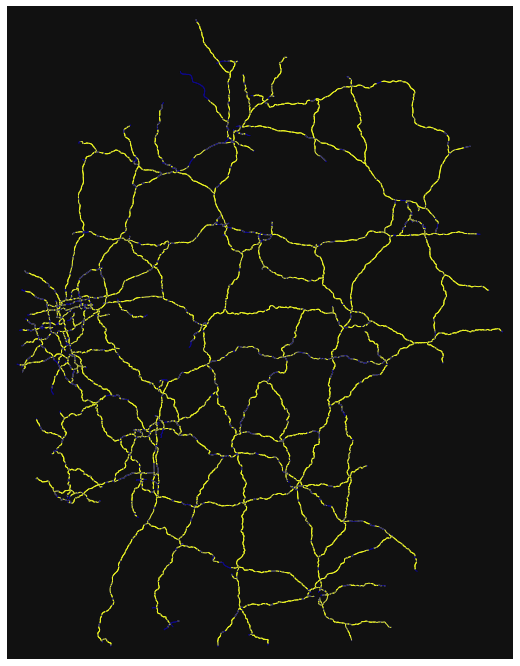

In [110]:
ec = ox.plot.get_edge_colors_by_attr(G, attr='visited', cmap='plasma', na_color="red")
fig, ax = ox.plot_graph(G, edge_color=ec, edge_linewidth=1, node_size=0, figsize=(12,12))
#fig.savefig("test.png", dpi=1000)

In [111]:
motorway_edges_total = 0
motorway_edges_visited = 0
for e, visited in nx.get_edge_attributes(G,"visited").items():
    if G.edges[e]["highway"] == "motorway":
        motorway_edges_total += 1
        if visited:
            motorway_edges_visited += 1
            
pct_visited = motorway_edges_visited/motorway_edges_total * 100
print("Percentage of edges visited by logic: ", pct_visited)

Percentage of edges visited by logic:  79.88797995430761


# ------------------------------------------------------------------------------

# Auxilary methods

# ------------------------------------------------------------------------------

## Aux I: Create distribution function for average cars per motorway per hour

In [16]:
tmp = pd.read_csv("data/car_distribution_data.csv", index_col="Stunde")

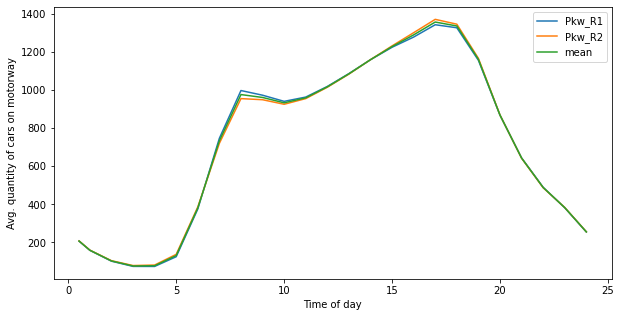

In [42]:
fig = plt.figure(figsize=(10,5))
ax1 = fig.add_subplot()
ax1.set_ylabel('Avg. quantity of cars on motorway')
ax1.set_xlabel('Time of day')
#ax1.set_title('a sine wave')

ax1.plot(tmp)
ax1.legend(tmp.columns)

In [18]:
pct_cars_by_hour = tmp["mean"].groupby(level=[0]).apply(lambda g: g / tmp["mean"].sum())

(0.0, 24.0)

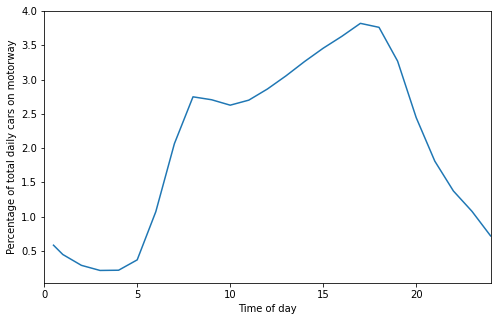

In [44]:
fig = plt.figure(figsize=(8,5))
ax1 = fig.add_subplot()
ax1.set_ylabel('Percentage of total daily cars on motorway')
ax1.set_xlabel('Time of day')
#ax1.set_title('a sine wave')

ax1.plot(pct_cars_by_hour * 100)
ax1.set_xlim([0, 24])
#ax1.legend(tmp.columns)

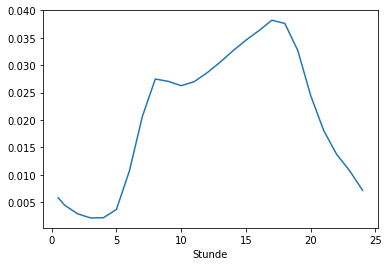

In [19]:
pct_cars_by_hour.plot()

In [20]:
def lookupCarPctByHour(time):
    idx = int(time[:-3])
    idx = 24 if time == "0:00" else idx
        
    nachkomma = .5 if time[-2:] == "30" else .0
    
    return pct_cars_by_hour[idx + nachkomma]

## Aux II: Energy Consumption Factors using COPERT

In [21]:
def calculateEnergyConsumptionFactor(kmh, cartype="mini", fueltype="petroleum"):
    '''
    Data Source: COPERT
    '''
    
    cartype = cartype.lower()
    fueltype = fueltype.lower()
    
    if fueltype == "benzin":
        fueltype = "petroleum"
    
    ### PETROLEUM CARS
    
    if cartype == "mini" and fueltype == "petroleum":
        Alpha, Beta, Gamma, Delta, Epsilon, Zita, Hta = 0.0050823704040405, -0.2720371338060150, 17.9186136039889000, 0.0000000000003375, 0.0008372940477115, 0.0971261095345315, 3.7213068787177500
        ReductionFactor = 0.0
        return (Alpha*kmh**2 + Beta*kmh + Gamma + (Delta/kmh) ) / (Epsilon*kmh**2 + Zita*kmh + Hta) * (1-ReductionFactor)
    
    
    if cartype == "small" and fueltype == "petroleum":
        Alpha, Beta, Gamma, Delta, Epsilon, Zita, Hta = 0.004797387395636090, -0.253329624090869000, 20.951609322668900000, 0.000000000000254117, 0.000800882509437353, 0.091328707216536800, 3.512642585251470000
        ReductionFactor = 0.0
        return (Alpha*kmh**2 + Beta*kmh + Gamma + (Delta/kmh) ) / (Epsilon*kmh**2 + Zita*kmh + Hta) * (1-ReductionFactor)
    
    if cartype == "medium" and fueltype == "petroleum":
        Alpha, Beta, Gamma, Delta, Epsilon, Zita, Hta = 0.00013172300677853800000, 0.00548595929528390000000, 2.61919505125660000000000, 0.00000000172774612390592, -0.00008504150126997990000, 0.02358438406740600000000, 0.34429757783387900000000
        ReductionFactor = 0.0
        return (Alpha*kmh**2 + Beta*kmh + Gamma + (Delta/kmh) ) / (Epsilon*kmh**2 + Zita*kmh + Hta) * (1-ReductionFactor)
    

    if (cartype == "large" or cartype == "SUV" or cartype == "Executive") and fueltype == "petroleum":
        Alpha, Beta, Gamma, Delta, Epsilon, Zita, Hta = 0.00000000000069991943473, -0.00156189755234097000000, 3.24524613527012000000000, 0.00000000285012757206809, -0.00010820134286967400000, 0.01893523507065330000000, 0.26009938300687900000000
        ReductionFactor = 0.0
        return (Alpha*kmh**2 + Beta*kmh + Gamma + (Delta/kmh) ) / (Epsilon*kmh**2 + Zita*kmh + Hta) * (1-ReductionFactor)
    
    
    ### DIESEL CARS
    
    if cartype == "mini" and fueltype == "diesel":
        Alpha, Beta, Gamma, Delta, Epsilon, Zita, Hta = 0.00921573924975886, 0.11073457438445200, 18.21292341849570000, -0.00000000000655600, 0.00129254380976794, 0.63134153084374500, 0.85316423086964100

        ReductionFactor = 0.0
        return (Alpha*kmh**2 + Beta*kmh + Gamma + (Delta/kmh) ) / (Epsilon*kmh**2 + Zita*kmh + Hta) * (1-ReductionFactor)
    
    if (cartype == "small" or cartype == "medium") and fueltype == "diesel":
        Alpha, Beta, Gamma, Delta, Epsilon, Zita, Hta = -0.00129911063069031000000, 0.22162498920771300000000, 16.43591461206050000000000, 0.00000000566298857668099, -0.00184467928314896000000, 0.29234727596213400000000, 2.37716402519569000000000

        ReductionFactor = 0.0
        return (Alpha*kmh**2 + Beta*kmh + Gamma + (Delta/kmh) ) / (Epsilon*kmh**2 + Zita*kmh + Hta) * (1-ReductionFactor)
    
    if (cartype == "large" or cartype == "SUV" or cartype == "Executive") and fueltype == "diesel":
        Alpha, Beta, Gamma, Delta, Epsilon, Zita, Hta = 0.000702861932235801, 0.013172543727278600, 13.711782089412000000, 0.000000000036243644, -0.000547098595260300, 0.118483099395406000, 1.647887335126100000

        ReductionFactor = 0.0
        return (Alpha*kmh**2 + Beta*kmh + Gamma + (Delta/kmh) ) / (Epsilon*kmh**2 + Zita*kmh + Hta) * (1-ReductionFactor)

In [22]:
def plotSingleECF(cartype, fueltype, minspeed=10, maxspeed=130, stepsize=5):

    x = [x for x in range(minspeed, maxspeed, stepsize)]
    y = [calculateEnergyConsumptionFactor(y, cartype=cartype, fueltype=fueltype) for y in x]

    # Plot
    plt.plot(x, y, "-o", alpha=0.5)
    plt.title(f'ECF for {fueltype} vehicles of category {cartype}')
    plt.xlabel('Velocity [km/h]')
    plt.ylabel('Energy Conversion Factor [MJ/km]')
    plt.show()

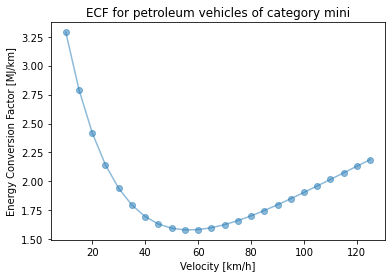

In [23]:
plotSingleECF(cartype="mini", fueltype="petroleum")

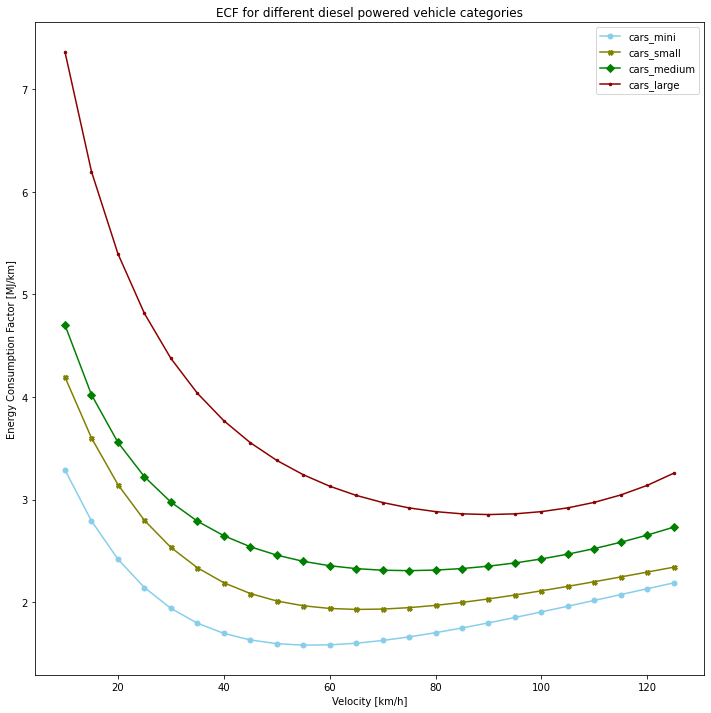

In [24]:
# DIESEL
minspeed=10
maxspeed=130
stepsize=5

fueltype = "petroleum"

# Data
df=pd.DataFrame({'x': range(minspeed,maxspeed, stepsize), 
                 'cars_mini': [calculateEnergyConsumptionFactor(x, cartype="mini", fueltype=fueltype) for x in range(minspeed,maxspeed, stepsize)], 
                 'cars_small': [calculateEnergyConsumptionFactor(x, cartype="small", fueltype=fueltype) for x in range(minspeed,maxspeed, stepsize)],
                 'cars_medium': [calculateEnergyConsumptionFactor(x, cartype="medium", fueltype=fueltype) for x in range(minspeed,maxspeed, stepsize)],
                 'cars_large': [calculateEnergyConsumptionFactor(x, cartype="large", fueltype=fueltype) for x in range(minspeed,maxspeed, stepsize)]
                })
 
# multiple line plot
fig, ax = plt.subplots(figsize=(12,12))

ax.plot( 'x', 'cars_mini', data=df, marker='o', markersize=5, color='skyblue')
ax.plot( 'x', 'cars_small', data=df, marker='X', markersize=5, color='olive')
ax.plot( 'x', 'cars_medium', data=df, marker='D', markersize=5, color='green')
ax.plot( 'x', 'cars_large', data=df, marker='.', markersize=5, color='darkred')

    
plt.legend(loc=1)

plt.title(f'ECF for different diesel powered vehicle categories')
plt.xlabel('Velocity [km/h]')
plt.ylabel('Energy Consumption Factor [MJ/km]')
plt.show()

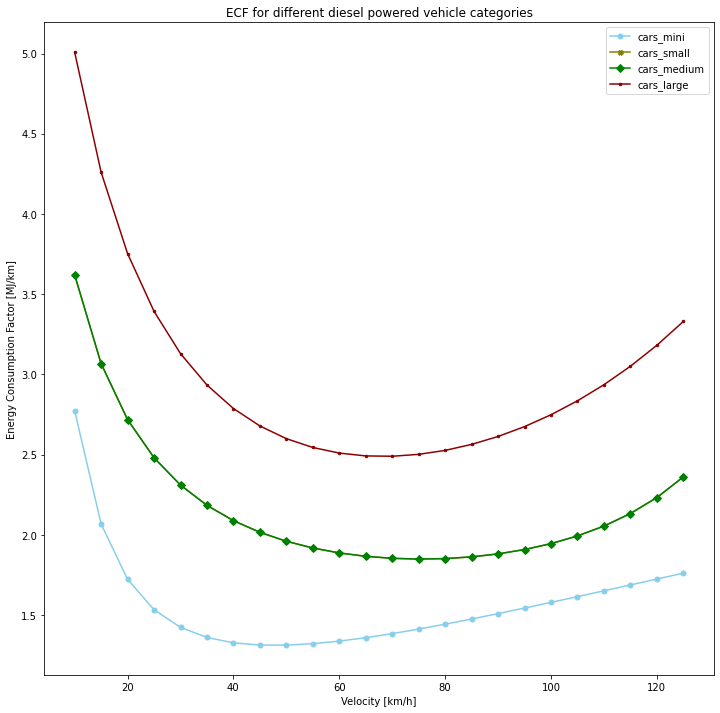

In [25]:
# DIESEL
minspeed=10
maxspeed=130
stepsize=5

fueltype = "diesel"

# Data
df=pd.DataFrame({'x': range(minspeed,maxspeed, stepsize), 
                 'cars_mini': [calculateEnergyConsumptionFactor(x, cartype="mini", fueltype=fueltype) for x in range(minspeed,maxspeed, stepsize)], 
                 'cars_small': [calculateEnergyConsumptionFactor(x, cartype="small", fueltype=fueltype) for x in range(minspeed,maxspeed, stepsize)],
                 'cars_medium': [calculateEnergyConsumptionFactor(x, cartype="medium", fueltype=fueltype) for x in range(minspeed,maxspeed, stepsize)],
                 'cars_large': [calculateEnergyConsumptionFactor(x, cartype="large", fueltype=fueltype) for x in range(minspeed,maxspeed, stepsize)]
                })
 
# multiple line plot
fig, ax = plt.subplots(figsize=(12,12))

ax.plot( 'x', 'cars_mini', data=df, marker='o', markersize=5, color='skyblue')
ax.plot( 'x', 'cars_small', data=df, marker='X', markersize=5, color='olive')
ax.plot( 'x', 'cars_medium', data=df, marker='D', markersize=5, color='green')
ax.plot( 'x', 'cars_large', data=df, marker='.', markersize=5, color='darkred')

    
plt.legend(loc=1)

plt.title(f'ECF for different diesel powered vehicle categories')
plt.xlabel('Velocity [km/h]')
plt.ylabel('Energy Consumption Factor [MJ/km]')
plt.show()

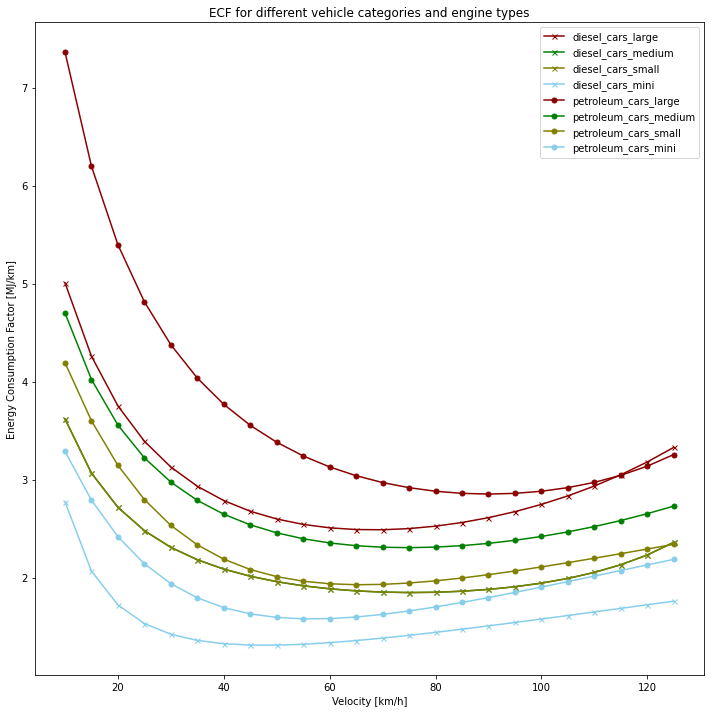

In [26]:
# BOTH
minspeed=10
maxspeed=130
stepsize=5



# Data
df=pd.DataFrame({'x': range(minspeed,maxspeed, stepsize), 
                 'diesel_cars_mini': [calculateEnergyConsumptionFactor(x, cartype="mini", fueltype="diesel") for x in range(minspeed,maxspeed, stepsize)], 
                 'diesel_cars_small': [calculateEnergyConsumptionFactor(x, cartype="small", fueltype="diesel") for x in range(minspeed,maxspeed, stepsize)],
                 'diesel_cars_medium': [calculateEnergyConsumptionFactor(x, cartype="medium", fueltype="diesel") for x in range(minspeed,maxspeed, stepsize)],
                 'diesel_cars_large': [calculateEnergyConsumptionFactor(x, cartype="large", fueltype="diesel") for x in range(minspeed,maxspeed, stepsize)],
                 'petroleum_cars_mini': [calculateEnergyConsumptionFactor(x, cartype="mini", fueltype="petroleum") for x in range(minspeed,maxspeed, stepsize)], 
                 'petroleum_cars_small': [calculateEnergyConsumptionFactor(x, cartype="small", fueltype="petroleum") for x in range(minspeed,maxspeed, stepsize)],
                 'petroleum_cars_medium': [calculateEnergyConsumptionFactor(x, cartype="medium", fueltype="petroleum") for x in range(minspeed,maxspeed, stepsize)],
                 'petroleum_cars_large': [calculateEnergyConsumptionFactor(x, cartype="large", fueltype="petroleum") for x in range(minspeed,maxspeed, stepsize)]
                })
 
# multiple line plot
fig, ax = plt.subplots(figsize=(12,12))

ax.plot( 'x', 'diesel_cars_large', data=df, marker='x', markersize=5, color='darkred')
ax.plot( 'x', 'diesel_cars_medium', data=df, marker='x', markersize=5, color='green')
ax.plot( 'x', 'diesel_cars_small', data=df, marker='x', markersize=5, color='olive')
ax.plot( 'x', 'diesel_cars_mini', data=df, marker='x', markersize=5, color='skyblue')


ax.plot( 'x', 'petroleum_cars_large', data=df, marker='o', markersize=5, color='darkred')
ax.plot( 'x', 'petroleum_cars_medium', data=df, marker='o', markersize=5, color='green')
ax.plot( 'x', 'petroleum_cars_small', data=df, marker='o', markersize=5, color='olive')
ax.plot( 'x', 'petroleum_cars_mini', data=df, marker='o', markersize=5, color='skyblue')




    
plt.legend(loc=1)

plt.title(f'ECF for different vehicle categories and engine types')
plt.xlabel('Velocity [km/h]')
plt.ylabel('Energy Consumption Factor [MJ/km]')
plt.show()

## Aux III: CO2e Emission calculation by Energy Consumption Factor

In [27]:
def calculateCO2eFromECF(ecf, numcars=1, fueltype="diesel"):
    '''
    Returns grams of CO2e generated per kilometer
    '''
    
    # Source: DIN EN 16258:2013-03
    CO2eGramsPerMJ_diesel = 71.0 # 1 Megajoule of Diesel E5 produces 71.0 grams of CO2e Tank-To-Wheel
    CO2eGramsPerMJ_petroleum = 75.2
    
    fueltype = fueltype.lower()
    
    if fueltype == "diesel":
        return CO2eGramsPerMJ_diesel * ecf * numcars
    elif fueltype == "petroleum" or fueltype == "benzin":
        return CO2eGramsPerMJ_petroleum * ecf * numcars

In [28]:
distributionData = pd.read_csv("data/Verteilung_Fahrzeugklassen.csv", sep=";", decimal=",")

In [29]:
distributionData

,Typ,COPERT Typ,Anzahl 2020 Benzin,Anzahl 2020 Diesel,Anzahl 2020 Gesamt,Anteil in % 2020 Benzin,Anteil in % 2020 Diesel
0,MINIS,Mini,2.203678e+06,1.076121e+06,3.279800e+06,0.048262,0.023568
1,KLEINWAGEN,Small,5.886766e+06,2.874682e+06,8.761447e+06,0.128924,0.062957
2,KOMPAKTKLASSE,Medium,7.895537e+06,3.855624e+06,1.175116e+07,0.172917,0.084441
3,MITTELKLASSE,Medium,4.142227e+06,2.022772e+06,6.164999e+06,0.090718,0.044300
4,OBERE MITTELKLASSE,Medium,1.267387e+06,6.189027e+05,1.886290e+06,0.027757,0.013554
5,OBERKLASSE,Large,1.775324e+05,8.669433e+04,2.642268e+05,0.003888,0.001899
6,SUVs,Large,2.481024e+06,1.211557e+06,3.692582e+06,0.054336,0.026534
7,GELÄNDEWAGEN,Large,1.709724e+06,8.349089e+05,2.544633e+06,0.037444,0.018285
8,SPORTWAGEN,Large,6.049298e+05,2.954051e+05,9.003349e+05,0.013248,0.006470
9,MINI-VANS,Large,1.315009e+06,6.421576e+05,1.957166e+06,0.028800,0.014064


In [30]:
distrDf_grouped = distributionData.groupby(["COPERT Typ"]).sum().iloc[:, 3:5]

In [31]:
distrDf_grouped

,Anteil in % 2020 Benzin,Anteil in % 2020 Diesel
COPERT Typ,,
Large,0.203317,0.099285
Medium,0.291392,0.142295
Mini,0.048262,0.023568
Small,0.128924,0.062957


In [34]:
distrDf_grouped.to_csv("data/COPERT_vehicle_distribution.csv", decimal=",")

In [49]:
def calculateAvgHistTravelSpeed(e, threshold=10000):
    avg = 0
    counter = 0
    if len(G.edges[(*e, 0)]["tomtomData"]) > 0:
        for time, data in G.edges[(*e, 0)]["tomtomData"].items():
            if data["historicTravelSpeed"] > threshold:
                avg += threshold
            else:
                avg += data["historicTravelSpeed"]
            counter += 1
    else:
        return None
    
    return avg / counter


In [50]:
def getEdgeSpeedByTime(e, reqTime="8:00"):
    if len(G.edges[(*e, 0)]["tomtomData"][reqTime]) > 0:
        return G.edges[(*e, 0)]["tomtomData"][reqTime]["historicTravelSpeed"]
    else:
        return None

In [51]:
def calculateEdgeCO2e(e, reqTime="8:00", restricted=False, threshold=120):
    '''
    Returns the total CO2e on any given edge in kilograms
    '''
    
    carsOnEdge = G.edges[(*e, 0)]["quantity_cars"]
    edgeLength = G.edges[(*e, 0)]["length"]
    
    edgeSpeed = getEdgeSpeedByTime(e, reqTime)
    if restricted and edgeSpeed is not None and edgeSpeed > threshold:
        edgeSpeed = threshold
    
    totalCO2eOnEdge = 0
    
    if edgeSpeed is not None:
            
        for idx, row in distrDf_grouped.iterrows(): # idx is the name of every car type in the dataframe
            carsInCategoryDiesel = carsOnEdge * row["Anteil in % 2020 Diesel"]
            carsInCategoryPetroleum = carsOnEdge * row["Anteil in % 2020 Benzin"]
            
            ECF_diesel = calculateEnergyConsumptionFactor(edgeSpeed, cartype=idx, fueltype="diesel")
            ECF_petroleum = calculateEnergyConsumptionFactor(edgeSpeed, cartype=idx, fueltype="petroleum")
            
            gramsCO2ePerKm_diesel = calculateCO2eFromECF(ECF_diesel, numcars=carsInCategoryDiesel, fueltype="diesel")
            gramsCO2ePerKm_petroleum = calculateCO2eFromECF(ECF_diesel, numcars=carsInCategoryPetroleum, fueltype="petroleum")
            
            totalCO2eOnEdge += (gramsCO2ePerKm_diesel + gramsCO2ePerKm_petroleum) * (edgeLength / 1000) * lookupCarPctByHour(reqTime)
    
    return totalCO2eOnEdge / 1000 # return in kilograms


In [52]:
def calculateRestrictedFlow(e, reqTime="8:00", restricted=False, threshold=120):
    '''
    Returns the total CO2e on any given edge in kilograms
    '''
    
    carsOnEdge = G.edges[(*e, 0)]["quantity_cars"]
    edgeLength = G.edges[(*e, 0)]["length"]
    restrictedFlow = 0
    
    edgeSpeed = getEdgeSpeedByTime(e, reqTime)
    if restricted and edgeSpeed is not None and edgeSpeed > threshold:
        restrictedFlow = carsOnEdge * edgeLength * lookupCarPctByHour(reqTime)
    
    return restrictedFlow

In [53]:
def calculateAvgEdgeCO2e(e, restricted=False, threshold=120):
    if len(G.edges[(*e, 0)]["tomtomData"]) > 0:
        data_dict = G.edges[(*e, 0)]["tomtomData"]
        times = data_dict.keys()
        avgCO2e = 0
        for time in times:
            avgCO2e += calculateEdgeCO2e(e, reqTime=time, restricted=restricted, threshold=threshold) 
        
        return avgCO2e
    return 0
    # Assumption: Distribution of car quantities is equally distributed throughout the day
    # Assumption 2: No cars between 23:00 and 4:00

In [54]:
def calculateAvgRestrictedFlow(e, restricted=False, threshold=120):
    if len(G.edges[(*e, 0)]["tomtomData"]) > 0:
        data_dict = G.edges[(*e, 0)]["tomtomData"]
        times = data_dict.keys()
        avgRestrictedFlow = 0
        for time in times:
            avgRestrictedFlow += calculateRestrictedFlow(e, reqTime=time, restricted=restricted, threshold=threshold) 
        
        return avgRestrictedFlow
    return 0
    # Assumption: Distribution of car quantities is equally distributed throughout the day
    # Assumption 2: No cars between 23:00 and 4:00

In [55]:
def calculateTotalFlow(e):
    if len(G.edges[(*e, 0)]["tomtomData"]) > 0:
        data_dict = G.edges[(*e, 0)]["tomtomData"]
        times = data_dict.keys()
        totalFlow = 0
        
        carsOnEdge = G.edges[(*e, 0)]["quantity_cars"]
        edgeLength = G.edges[(*e, 0)]["length"]
        for time in times:
            totalFlow += carsOnEdge * edgeLength * lookupCarPctByHour(time)
        
        return totalFlow
    return 0
    # Assumption: Distribution of car quantities is equally distributed throughout the day
    # Assumption 2: No cars between 23:00 and 4:00

# ------------------------------------------------------------------------------

# Analytics

# ------------------------------------------------------------------------------

In [56]:
motorway_length_total = 0
motorway_length_visited = 0
for e, visited in nx.get_edge_attributes(G,"visited").items():
    if G.edges[e]["highway"] == "motorway":
        motorway_length_total +=  G.edges[e]["length"]
        if visited:
            motorway_length_visited += G.edges[e]["length"]
            
pct_visited = motorway_length_visited/motorway_length_total * 100
print("Percentage of motorway network visited by logic: ", pct_visited)
print("Total Motorway Length:", motorway_length_total, "Length of motorway visited: ", motorway_length_visited)

Percentage of motorway network visited by logic:  84.85314300131061
Total Motorway Length: 4591449.342000011 Length of motorway visited:  3895989.076000005


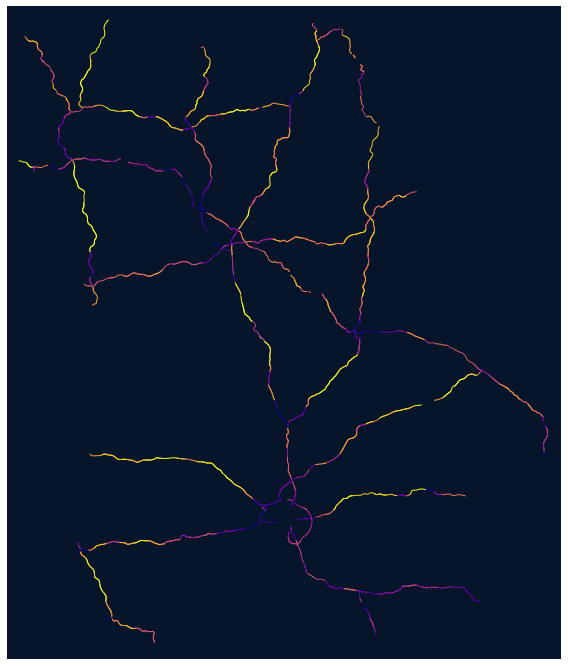

In [57]:
reqAttr = "travelSpeed"
reqTime = "15:30"

ec, bin_colors, intervals = get_edge_colors_by_TomTom_Attribute(G, cmap="plasma", requestedAttribute=reqAttr, requestedTime=reqTime, na_color="none", num_bins=10, equal_size=True)
fig, ax = ox.plot_graph(G, edge_color=ec, edge_linewidth=1, node_size=0, figsize=(12,12), bgcolor = "#061529")

fontsize = 8
custom_patches = []
for idx, c in enumerate(bin_colors):
    label_str = str(round(intervals[idx],2)) + " km/h" + " - " + str(round(intervals[idx+1],2)) + " km/h"
    custom_patches.append(mpatches.Patch(color=c, label=label_str))

# for reference: https://towardsdatascience.com/making-artistic-maps-with-python-9d37f5ea8af0
l = ax.legend(handles=custom_patches, frameon=True, ncol=1,
              facecolor = '#061529', framealpha = 0.9,
              loc='upper right',  fontsize = fontsize, prop={'family':"Georgia", 'size':fontsize})
# Legend font color
for text in l.get_texts():
    text.set_color("w")
    
# Save figure
fig.suptitle(f'Bavarian Motorway Network "{reqAttr}" at {reqTime}', fontsize=20, color="black", y=0.92)
fname = "Network_{}_{}.png".format(reqAttr, reqTime.replace(":", "_"))
fig.savefig(fname, dpi=300, bbox_inches='tight', format="png", facecolor=fig.get_facecolor(), transparent=False)

## Analysis Gewichtet

### Q: What is the percentage of unrestricted roads in the network?

In [58]:
motorway_length_total = 0
motorway_length_unrestricted = 0
motorway_flow_unrestricted = 0
flow_kilometers_unrestricted = 0
total_flow_kilometers = 0

totalCarQuantity = 0

for e, maxspeed in nx.get_edge_attributes(G,"maxspeed").items():
    if G.edges[e]["highway"] == "motorway":
        if maxspeed == "none":
            edge_car_quantity = G.edges[e]["quantity_cars"] # Assumption: Autos sind zu jedem Zeitpunkt gleichverteilt über das Netzwerk (auf allen Edges)
            motorway_flow_unrestricted += edge_car_quantity
            motorway_length_unrestricted += G.edges[e]["length"]
            flow_kilometers_unrestricted += G.edges[e]["length"] * edge_car_quantity
        
        motorway_length_total +=  G.edges[e]["length"]
        total_flow_kilometers += G.edges[e]["length"] * G.edges[e]["quantity_cars"]
        totalCarQuantity += G.edges[e]["quantity_cars"]
            
pct_unrestricted = motorway_length_unrestricted/motorway_length_total * 100
pct_flow_unrestricted = motorway_flow_unrestricted/totalCarQuantity * 100
pct_flow_kilometers_unrestricted = flow_kilometers_unrestricted/total_flow_kilometers * 100
print("Percentage of motorway network that is unrestricted: ", pct_unrestricted)
print("Percentage of network flow that is unrestricted: ", pct_flow_unrestricted)
print("Percentage of flow kilometers unrestricted: ", pct_flow_kilometers_unrestricted)

Percentage of motorway network that is unrestricted:  65.20450095054801
Percentage of network flow that is unrestricted:  64.40752791164309
Percentage of flow kilometers unrestricted:  64.87322142976946


### Q: What is the percentage of motorway kilometers which would be affected by a speed restriction of 120 km/h in terms of official road regulations?

In [59]:
threshold = 120

motorway_length_total = 0
total_flow_kilometers = 0

motorway_length_under_threshold = 0
motorway_flow_under_threshold = 0
flow_kilometers_under_threshold = 0

motorway_length_above_threshold = 0
motorway_flow_above_threshold = 0
flow_kilometers_above_threshold = 0

totalCarQuantity = 0

for e, speedlimit in nx.get_edge_attributes(G,"maxspeed").items():
    if G.edges[e]["highway"] == "motorway":
        
        if speedlimit == "none":
            speedlimit = 10000
        if speedlimit == "signals":
            speedlimit = 120 # assumption
        if isinstance(speedlimit, list):
            speedlimit = getSpeedLimitFromList(speedlimit)
    
        if int(speedlimit) <= threshold:
            motorway_length_under_threshold += G.edges[e]["length"]
            motorway_flow_under_threshold += G.edges[e]["quantity_cars"]
            flow_kilometers_under_threshold += G.edges[e]["length"] * G.edges[e]["quantity_cars"]
            
        else:
            motorway_length_above_threshold += G.edges[e]["length"]
            motorway_flow_above_threshold += G.edges[e]["quantity_cars"]
            flow_kilometers_above_threshold += G.edges[e]["length"] * G.edges[e]["quantity_cars"]


        motorway_length_total +=  G.edges[e]["length"]
        total_flow_kilometers += G.edges[e]["length"] * G.edges[e]["quantity_cars"]
        totalCarQuantity += G.edges[e]["quantity_cars"]
            
pct_under_threshold = motorway_length_under_threshold/motorway_length_total * 100
pct_above_threshold = motorway_length_above_threshold/motorway_length_total * 100

pct_flow_under_threshold = motorway_flow_under_threshold / totalCarQuantity * 100
pct_flow_above_threshold = motorway_flow_above_threshold / totalCarQuantity * 100

pct_flow_kilometers_under_threshold = flow_kilometers_under_threshold / total_flow_kilometers * 100
pct_flow_kilometers_above_threshold = flow_kilometers_above_threshold / total_flow_kilometers * 100

print(f"Percentage of motorway network where speedlimit is under or at threshold of {threshold} km/h: ", pct_under_threshold)
print(f"Percentage of motorway network that would be affected by speedlimit of {threshold} km/h: ", pct_above_threshold)
print("---"*30)

print(f"Percentage of motorway network flow where speedlimit is under or at threshold of {threshold} km/h: ", pct_flow_under_threshold)
print(f"Percentage of motorway network flow where speedlimit is above threshold of {threshold} km/h: ", pct_flow_above_threshold)
print("---"*30)

print(f"Percentage of flow kilometers where speedlimit is under or at threshold of {threshold} km/h: ", pct_flow_kilometers_under_threshold)
print(f"Percentage of flow kilometers that would be affected by speedlimit of {threshold} km/h: ", pct_flow_kilometers_above_threshold)


Percentage of motorway network where speedlimit is under or at threshold of 120 km/h:  30.152992666444483
Percentage of motorway network that would be affected by speedlimit of 120 km/h:  69.84700733355528
------------------------------------------------------------------------------------------
Percentage of motorway network flow where speedlimit is under or at threshold of 120 km/h:  32.76941005667213
Percentage of motorway network flow where speedlimit is above threshold of 120 km/h:  67.23058994332789
------------------------------------------------------------------------------------------
Percentage of flow kilometers where speedlimit is under or at threshold of 120 km/h:  31.18959167693437
Percentage of flow kilometers that would be affected by speedlimit of 120 km/h:  68.81040832306572


### Q: What is the percentage of motorway kilometers which would be affected by a speed restriction of 120 km/h in terms of actual traffic speeds?

In [60]:
def printResults(thresholdAttribute, reqTime, pct_forced_under_speedLimit, pct_naturally_under_speedLimit, pct_above_speedLimit, pct_that_would_be_restricted, 
                pct_flow_kilometers_forced_under_speedLimit, pct_flow_kilometers_naturally_under_speedLimit, pct_flow_kilometers_above_speedLimit, pct_flow_kilometers_that_would_be_restricted, 
                 avgSpeedRestrictionMw, avgSpeedRestrictionFlowKm, avgPctSpeedRestrictionMw, avgPctSpeedRestrictionFlowKm):
    print(f"Percentage of motorway network where {thresholdAttribute} is externally forced under speedlimit and delayed at {reqTime}: ", pct_forced_under_speedLimit)
    print(f"Percentage of motorway network where {thresholdAttribute} is naturally under speedlimit at {reqTime}: ", pct_naturally_under_speedLimit)
    print("Percentage of motorway network that is at or above speedlimit: ", pct_above_speedLimit)
    print(f"Percentage of motorway network that would be restricted by threshold of {threshold}km/h: ", pct_that_would_be_restricted)
    print(f"Average speed restriction in km/h:", avgSpeedRestrictionMw)
    print(f"Average percentage speed restriction", avgPctSpeedRestrictionMw)
    print("---"*30)

    print("\nFlow Kilometers:")
    print(f"Percentage of flow kilometers where {thresholdAttribute} is externally forced under speedlimit and delayed at {reqTime}: ", pct_flow_kilometers_forced_under_speedLimit)
    print(f"Percentage of flow kilometers where {thresholdAttribute} is naturally under speedlimit at {reqTime}: ", pct_flow_kilometers_naturally_under_speedLimit)
    print("Percentage of flow kilometers that is at or above speedlimit: ", pct_flow_kilometers_above_speedLimit)
    print(f"Percentage of flow kilometers that would be restricted by threshold of {threshold}km/h: ", pct_flow_kilometers_that_would_be_restricted)
    
    print(f"Average speed restriction in km/h:", avgSpeedRestrictionFlowKm)
    print(f"Average percentage speed restriction", avgPctSpeedRestrictionFlowKm)

In [61]:
### NEU

def doMotorwayAnalysis(G, reqTime="8:00", thresholdAttribute = "historicTravelSpeed", threshold = 120):
    # reqTime = "12:30"
    # thresholdAttribute = "historicTravelSpeed"
    # threshold = 120

    edgesForcedUnderSpeedlimit = []
    edgesPotentiallyRestricted = []
    edgesNaturallyUnderSpeedlimit = []
    edgesRestrictedByThreshold = []

    motorway_length_total = 0
    motorway_length_where_speed_is_naturally_under_limit = 0
    motorway_length_where_speed_externally_forced_under_limit = 0
    motorway_length_where_speed_is_at_or_above_speedlimit = 0
    motorway_length_restricted_by_threshold = 0
    motorway_length_above_speedLimit = 0
    motorway_length_restricted = 0
    total_flow_kilometers = 0

    flow_kilometers_where_speed_externally_forced_under_limit = 0
    flow_kilometers_where_speed_is_naturally_under_limit = 0
    flow_kilometers_where_speed_is_at_or_above_speedlimit = 0
    flow_kilometers_restricted_by_threshold = 0
    
    speedRestrictionMw = 0
    speedRestrictionFlowKm = 0
    pctSpeedRestrictionMw = 0
    pctSpeedRestrictionFlowKm = 0
    restrictionCounter = 0

    for e, speedlimit in nx.get_edge_attributes(G,"maxspeed").items():
        if G.edges[e]["highway"] == "motorway":
            if G.edges[e]["tomtomData"] is None or reqTime not in G.edges[e]["tomtomData"]:
                continue
            travelSpeed = G.edges[e]["tomtomData"][reqTime][thresholdAttribute]
            noTrafficTravelSpeed = G.edges[e]["tomtomData"][reqTime]["noTrafficTravelSpeed"]
            trafficDelay = G.edges[e]["tomtomData"][reqTime]["historicTrafficTravelTimeInSeconds"] - G.edges[e]["tomtomData"][reqTime]["noTrafficTravelTimeInSeconds"]

            if speedlimit == "none":
                speedlimit = 10000
            if speedlimit == "signals":
                speedlimit = 120 # assumption
            if isinstance(speedlimit, list):
                speedlimit = getSpeedLimitFromList(speedlimit)

            n1,n2, _ = e

            # Tatsächliche Geschwindigkeit ist kleiner als Maximalgeschwindigkeit aufgrund von Stauverzögerungen
            if  travelSpeed < int(speedlimit) and trafficDelay > 0: 
                motorway_length_where_speed_externally_forced_under_limit += G.edges[e]["length"]
                flow_kilometers_where_speed_externally_forced_under_limit += G.edges[e]["length"] * G.edges[e]["quantity_cars"]
                edgesForcedUnderSpeedlimit.append((n1,n2))

            # Tatsächliche Geschwindigkeit liegt auch ohne Stau historisch immer unter Maximalgeschwindigkeit
            if travelSpeed < int(speedlimit) and trafficDelay == 0: 
                motorway_length_where_speed_is_naturally_under_limit += G.edges[e]["length"]
                flow_kilometers_where_speed_is_naturally_under_limit += G.edges[e]["length"] * G.edges[e]["quantity_cars"]
                edgesNaturallyUnderSpeedlimit.append((n1,n2))

            if travelSpeed >= int(speedlimit):
                motorway_length_where_speed_is_at_or_above_speedlimit += G.edges[e]["length"]
                flow_kilometers_where_speed_is_at_or_above_speedlimit += G.edges[e]["length"] * G.edges[e]["quantity_cars"]
            
            # HIER LAG DER FEHLER!!!!!!!!!!!
            # ##################
            # VORHER: if travelSpeed < threshold
            if travelSpeed > threshold:
                motorway_length_restricted_by_threshold += G.edges[e]["length"]
                flow_kilometers_restricted_by_threshold += G.edges[e]["length"] * G.edges[e]["quantity_cars"]
                speedRestrictionMw += (travelSpeed - threshold) * G.edges[e]["length"]
                speedRestrictionFlowKm += (travelSpeed - threshold) * G.edges[e]["quantity_cars"] * G.edges[e]["length"]
                
                pctSpeedRestrictionMw += (travelSpeed - threshold) / travelSpeed * G.edges[e]["length"]
                pctSpeedRestrictionFlowKm += (travelSpeed - threshold) / travelSpeed * G.edges[e]["quantity_cars"] * G.edges[e]["length"]
                restrictionCounter += 1

            motorway_length_total +=  G.edges[e]["length"]
            total_flow_kilometers += G.edges[e]["length"] * G.edges[e]["quantity_cars"]

    pct_forced_under_speedLimit = motorway_length_where_speed_externally_forced_under_limit/motorway_length_total * 100
    pct_naturally_under_speedLimit = motorway_length_where_speed_is_naturally_under_limit/motorway_length_total * 100
    pct_above_speedLimit = motorway_length_where_speed_is_at_or_above_speedlimit/motorway_length_total * 100
    pct_that_would_be_restricted = motorway_length_restricted_by_threshold/motorway_length_total * 100

    pct_flow_kilometers_forced_under_speedLimit = flow_kilometers_where_speed_externally_forced_under_limit/total_flow_kilometers * 100
    pct_flow_kilometers_naturally_under_speedLimit = flow_kilometers_where_speed_is_naturally_under_limit/total_flow_kilometers * 100
    pct_flow_kilometers_above_speedLimit = flow_kilometers_where_speed_is_at_or_above_speedlimit/total_flow_kilometers * 100
    pct_flow_kilometers_that_would_be_restricted = flow_kilometers_restricted_by_threshold/total_flow_kilometers * 100
    
    avgSpeedRestrictionMw = speedRestrictionMw / motorway_length_total
    avgSpeedRestrictionFlowKm = speedRestrictionFlowKm / total_flow_kilometers
    
    avgPctSpeedRestrictionMw = pctSpeedRestrictionMw / motorway_length_total
    avgPctSpeedRestrictionFlowKm = pctSpeedRestrictionFlowKm / total_flow_kilometers

    return (thresholdAttribute, reqTime, pct_forced_under_speedLimit, pct_naturally_under_speedLimit, pct_above_speedLimit, pct_that_would_be_restricted,
                    pct_flow_kilometers_forced_under_speedLimit, pct_flow_kilometers_naturally_under_speedLimit, 
                    pct_flow_kilometers_above_speedLimit, pct_flow_kilometers_that_would_be_restricted, 
            avgSpeedRestrictionMw, 
            avgSpeedRestrictionFlowKm,
            avgPctSpeedRestrictionMw,
            avgPctSpeedRestrictionFlowKm
           )

In [62]:
printResults(*doMotorwayAnalysis(G, reqTime="17:30"))

Percentage of motorway network where historicTravelSpeed is externally forced under speedlimit and delayed at 17:30:  75.56437091342774
Percentage of motorway network where historicTravelSpeed is naturally under speedlimit at 17:30:  7.920103571599939
Percentage of motorway network that is at or above speedlimit:  16.515525514972204
Percentage of motorway network that would be restricted by threshold of 120km/h:  71.36612268254814
Average speed restriction in km/h: 8.052711950204294
Average percentage speed restriction 0.06006094131139176
------------------------------------------------------------------------------------------

Flow Kilometers:
Percentage of flow kilometers where historicTravelSpeed is externally forced under speedlimit and delayed at 17:30:  76.2149996061774
Percentage of flow kilometers where historicTravelSpeed is naturally under speedlimit at 17:30:  7.758725944443007
Percentage of flow kilometers that is at or above speedlimit:  16.026274449379656
Percentage of f

In [63]:
def calculateDailyAvgStatistics(thresholdAttribute = "historicTravelSpeed", thresholds = [120]):
    relevantDepartures = [f"{i}:{3*h}0" for i in range(4,24) for h in range(0,2)]
    
    mwNetworkDf = pd.DataFrame(columns=["speedLimit", "avgPctForcedUnder", "avgPctNaturallyUnder", "avgPctAbove","avgPctRestricted", "avgSpeedRestrictionKmh", "avgPctSpeedRestriction"])
    flowKmDf = pd.DataFrame(columns=["speedLimit", "avgPctForcedUnder", "avgPctNaturallyUnder", "avgPctAbove","avgPctRestricted", "avgSpeedRestrictionKmh", "avgPctSpeedRestriction"])

    for thres in thresholds:
        avgPct_forced_under_speedLimit = 0
        avgPct_naturally_under_speedLimit = 0 
        avgPct_above_speedLimit = 0
        avgPct_that_would_be_restricted = 0
        avgPct_flow_kilometers_forced_under_speedLimit = 0 
        avgPct_flow_kilometers_naturally_under_speedLimit = 0 
        avgPct_flow_kilometers_above_speedLimit = 0
        avgPct_flow_kilometers_that_would_be_restricted = 0
        avgSpeedRestrictionMw = 0
        avgSpeedRestrictionFlowKm = 0
        avgPctSpeedRestrictionMw = 0
        avgPctSpeedRestrictionFlowKm = 0

        for ts in relevantDepartures:
            results = doMotorwayAnalysis(G, reqTime=ts, thresholdAttribute=thresholdAttribute, threshold=thres)
            carPct = lookupCarPctByHour(ts)
            avgPct_forced_under_speedLimit += results[2] * carPct
            avgPct_naturally_under_speedLimit += results[3] * carPct
            avgPct_above_speedLimit += results[4] * carPct
            avgPct_that_would_be_restricted += results[5] * carPct
            avgSpeedRestrictionMw += results[10] * carPct
            avgPctSpeedRestrictionMw += results[12] * carPct
            
            avgPct_flow_kilometers_forced_under_speedLimit += results[6] * carPct
            avgPct_flow_kilometers_naturally_under_speedLimit += results[7] * carPct
            avgPct_flow_kilometers_above_speedLimit += results[8] * carPct
            avgPct_flow_kilometers_that_would_be_restricted += results[9] * carPct
            avgSpeedRestrictionFlowKm += results[11] * carPct
            avgPctSpeedRestrictionFlowKm += results[13] * carPct
            
        new_rowMw = {"speedLimit": thres, 
                     "avgPctForcedUnder": avgPct_forced_under_speedLimit, 
                     "avgPctNaturallyUnder": avgPct_naturally_under_speedLimit, 
                     "avgPctAbove": avgPct_above_speedLimit,
                     "avgPctRestricted": avgPct_that_would_be_restricted,
                    "avgSpeedRestrictionKmh": avgSpeedRestrictionMw,
                    "avgPctSpeedRestriction": avgPctSpeedRestrictionMw * 100}
        
        new_rowFk = {"speedLimit": thres, 
                     "avgPctForcedUnder": avgPct_flow_kilometers_forced_under_speedLimit, 
                     "avgPctNaturallyUnder": avgPct_flow_kilometers_naturally_under_speedLimit, 
                     "avgPctAbove": avgPct_flow_kilometers_above_speedLimit,
                     "avgPctRestricted": avgPct_flow_kilometers_that_would_be_restricted,
                    "avgSpeedRestrictionKmh": avgSpeedRestrictionFlowKm,
                    "avgPctSpeedRestriction": avgPctSpeedRestrictionFlowKm * 100}
        
        mwNetworkDf = mwNetworkDf.append(new_rowMw, ignore_index=True)
        flowKmDf = flowKmDf.append(new_rowFk, ignore_index=True)
    
    return mwNetworkDf, flowKmDf
#         printResults(thresholdAttribute, "daily avg", avgPct_forced_under_speedLimit, avgPct_naturally_under_speedLimit, avgPct_above_speedLimit, avgPct_that_would_be_restricted, 
#                         avgPct_flow_kilometers_forced_under_speedLimit, avgPct_flow_kilometers_naturally_under_speedLimit, avgPct_flow_kilometers_above_speedLimit, avgPct_flow_kilometers_that_would_be_restricted)

In [64]:
relevantThresholds = [60, 70, 80,90,100,110, 120, 130]

In [65]:
mwNetwork, flowKm = calculateDailyAvgStatistics(thresholds = relevantThresholds)

## Analysis CO2

In [66]:
colDataPct = []
colDataAbs = []
for thres in relevantThresholds:
    totalCO2e = 0
    totalCO2e_restricted = 0
    for e in G.edges():
        totalCO2e += calculateAvgEdgeCO2e(e)
        totalCO2e_restricted += calculateAvgEdgeCO2e(e, restricted=True, threshold=thres)

    #print("Daily CO2e Emission savings:", round((1 - totalCO2e_restricted / totalCO2e) * 100,2), "Percent")
    colDataPct.append(round((1 - totalCO2e_restricted / totalCO2e) * 100,2))
    colDataAbs.append(round((totalCO2e - totalCO2e_restricted) / 1000, 2))

mwNetwork["CO2eSavingsPct"] = colDataPct
mwNetwork["CO2eSavingsAbs"] = colDataAbs
flowKm["CO2eSavingsPct"] = colDataPct
flowKm["CO2eSavingsAbs"] = colDataAbs

In [67]:
mwNetwork[["speedLimit", "avgPctRestricted", "CO2eSavingsPct","CO2eSavingsAbs", "avgSpeedRestrictionKmh", "avgPctSpeedRestriction"]]

,speedLimit,avgPctRestricted,CO2eSavingsPct,CO2eSavingsAbs,avgSpeedRestrictionKmh,avgPctSpeedRestriction
0,60.0,96.564803,24.32,5370.15,63.453719,49.851245
1,70.0,96.244454,25.19,5562.69,53.811015,42.087269
2,80.0,95.658258,24.67,5447.45,44.214075,34.388169
3,90.0,94.080728,22.90,5056.87,34.723675,26.819502
4,100.0,91.467821,19.90,4393.34,25.426440,19.464340
5,110.0,85.839532,15.60,3444.06,16.516428,12.491550
6,120.0,72.593830,10.03,2215.71,8.493960,6.317170
7,130.0,44.617431,3.96,873.94,2.509071,1.824659


In [68]:
flowKm[["speedLimit", "avgPctRestricted", "CO2eSavingsPct","CO2eSavingsAbs", "avgSpeedRestrictionKmh", "avgPctSpeedRestriction"]]

,speedLimit,avgPctRestricted,CO2eSavingsPct,CO2eSavingsAbs,avgSpeedRestrictionKmh,avgPctSpeedRestriction
0,60.0,96.447720,24.32,5370.15,62.585022,49.406049
1,70.0,96.049146,25.19,5562.69,52.957170,41.592333
2,80.0,95.313626,24.67,5447.45,43.388493,33.862488
3,90.0,93.358258,22.90,5056.87,33.947355,26.288682
4,100.0,90.387143,19.90,4393.34,24.738365,18.972041
5,110.0,84.228690,15.60,3444.06,15.967500,12.088252
6,120.0,69.859510,10.03,2215.71,8.151025,6.063037
7,130.0,42.888924,3.96,873.94,2.399402,1.745264


In [286]:
# mwNetwork.to_csv("results/motorwayNetworkResults.csv", index=False)
# flowKm.to_csv("results/flowKmResults.csv", index=False, decimal=",")

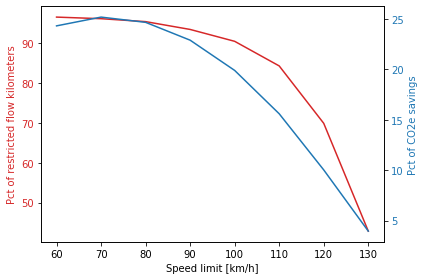

In [69]:
t = flowKm["speedLimit"]
data1 = flowKm["avgPctRestricted"]
data2 = flowKm["CO2eSavingsPct"]

fig, ax1 = plt.subplots()

color = 'tab:red'
ax1.set_xlabel('Speed limit [km/h]')
ax1.set_ylabel('Pct of restricted flow kilometers', color=color)
ax1.plot(t, data1, color=color)
ax1.tick_params(axis='y', labelcolor=color)

ax2 = ax1.twinx()  # instantiate a second axes that shares the same x-axis

color = 'tab:blue'
ax2.set_ylabel('Pct of CO2e savings', color=color)  # we already handled the x-label with ax1
ax2.plot(t, data2, color=color)
ax2.tick_params(axis='y', labelcolor=color)

fig.tight_layout()  # otherwise the right y-label is slightly clipped
plt.show()

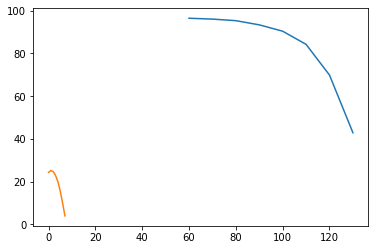

In [70]:
plt.plot(flowKm["speedLimit"], flowKm["avgPctRestricted"], flowKm["CO2eSavingsPct"])

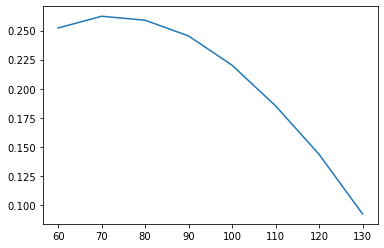

In [71]:
plt.plot(flowKm["speedLimit"], flowKm["CO2eSavingsPct"] / flowKm["avgPctRestricted"])

In [72]:
from pandas.plotting import parallel_coordinates

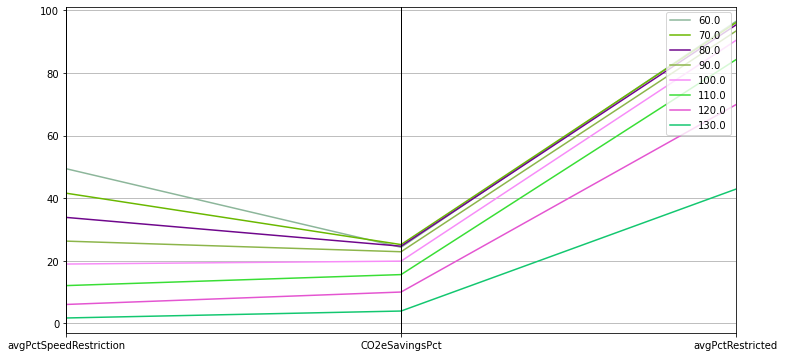

In [78]:
fig, ax1 = plt.subplots()
fig.set_size_inches(12, 6)
ax1 = parallel_coordinates(flowKm, "speedLimit", cols=["avgPctSpeedRestriction", "CO2eSavingsPct", "avgPctRestricted" ])

## Visualize percentage difference between unrestricted and restricted network state in terms of CO2e 

In [95]:
CO2_dict = {}
restricted_dict = {}
totalFlow_dict = {}

counter = 0
total = 0

for e in G.edges():
    if G.edges[(*e, 0)]["highway"] == "motorway":
        total += 1
    CO2e = calculateAvgEdgeCO2e(e)
    CO2e_restricted = calculateAvgEdgeCO2e(e, restricted=True)
    restrictedFlow = calculateAvgRestrictedFlow(e, restricted=True)
    totalFlow = calculateTotalFlow(e)
    
    if CO2e > 0: # If TomTomData is available
        pct_diff = 1 - CO2e_restricted / CO2e
        CO2_dict[(*e, 0)] = pct_diff
        restricted_dict[(*e, 0)] = restrictedFlow
        totalFlow_dict[(*e, 0)] = totalFlow
    else:
        CO2_dict[(*e, 0)] = None
        restricted_dict[(*e, 0)] = None
        totalFlow_dict[(*e, 0)] = None
        if G.edges[(*e, 0)]["highway"] == "motorway":
            counter += 1

In [96]:
counter / total

0.1607069461570078

In [97]:
# DONT COMMENT THIS OUT!
# For whatever reason, if graph contains duplicate nodes, the attribute has first be set None before assigning attributes via dictionary
nx.set_edge_attributes(G, None, "CO2e_savings_pct")
nx.set_edge_attributes(G, None, "restrictedFlow")
nx.set_edge_attributes(G, None, "totalFlow")

nx.set_edge_attributes(G, CO2_dict, "CO2e_savings_pct")
nx.set_edge_attributes(G, restricted_dict, "restrictedFlow")
nx.set_edge_attributes(G, totalFlow_dict, "totalFlow")

Network colored by Percentage savings in CO2e per Edge between unrestricted and restricted state of the Network


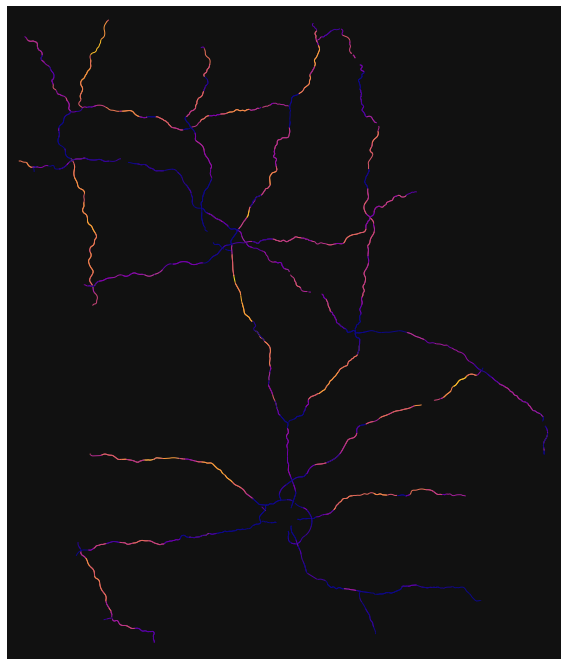

In [98]:
print("Network colored by Percentage savings in CO2e per Edge between unrestricted and restricted state of the Network")
ec = ox.plot.get_edge_colors_by_attr(G, attr='CO2e_savings_pct', cmap='plasma', na_color="None", equal_size=True)
fig, ax = ox.plot_graph(G, edge_color=ec, edge_linewidth=1, node_size=0, figsize=(12,12))
#fig.savefig("test.png", dpi=1000)

## Visualize absolute difference between unrestricted and restricted network state in terms of CO2e 

In [99]:
CO2_dict_abs = {}
counter = 0
for e in G.edges():
    CO2e = calculateAvgEdgeCO2e(e)
    CO2e_restricted = calculateAvgEdgeCO2e(e, restricted=True)
    if CO2e > 0: # If TomTomData is available
        abs_diff = CO2e - CO2e_restricted
        if abs_diff < 0:
            counter += 1
        CO2_dict_abs[(*e, 0)] = abs_diff
    else:
        CO2_dict_abs[(*e, 0)] = None

Network colored by absolute savings in CO2e per Edge between unrestricted and restricted state of the Network


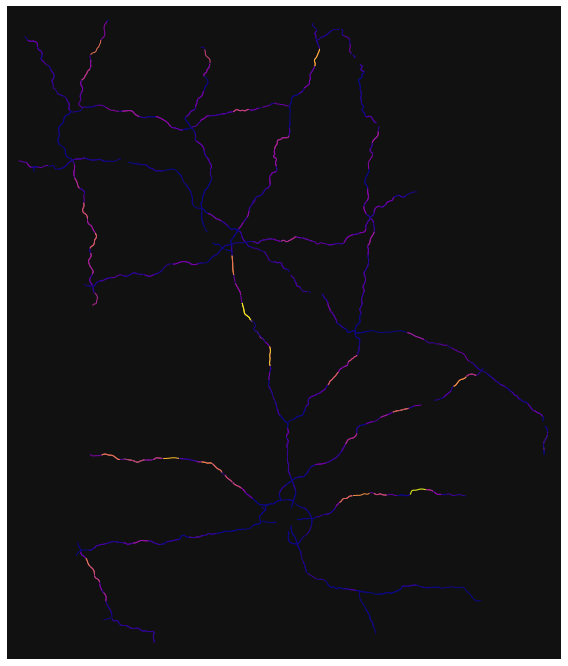

In [100]:
print("Network colored by absolute savings in CO2e per Edge between unrestricted and restricted state of the Network")
ec = ox.plot.get_edge_colors_by_attr(G, attr='CO2e_savings_abs', cmap='plasma', na_color="None", equal_size=True)
fig, ax = ox.plot_graph(G, edge_color=ec, edge_linewidth=1, node_size=0, figsize=(12,12))
#fig.savefig("test.png", dpi=1000)

In [101]:
test = nx.get_edge_attributes(G, "CO2e_savings_abs")

In [102]:
resFlowsByEdge = nx.get_edge_attributes(G, "restrictedFlow")

In [103]:
totalFlows = nx.get_edge_attributes(G, "totalFlow")

In [104]:
highwayType = nx.get_edge_attributes(G, "highway")

In [105]:
test = { k: (0 if v is None else v) for k, v in test.items() }
resFlowsByEdge = { k: (1 if v is None else v) for k, v in resFlowsByEdge.items() }
totalFlows = { k: (1 if v is None else v) for k, v in totalFlows.items() }

In [106]:
co2DF = pd.DataFrame([test, resFlowsByEdge, totalFlows, highwayType]).T
co2DF.columns = ["CO2eSavingsAbs", "restrictedFlow", "totalFlow", "highway"]

In [107]:
co2DF = co2DF.loc[co2DF["highway"] != "motorway_link"]

In [108]:
co2DF["savingsPerRestrictedMeter"] = co2DF["CO2eSavingsAbs"] / co2DF["restrictedFlow"]

In [109]:
co2DF.sort_values(by=["savingsPerRestrictedMeter"], ascending=False, inplace=True)

In [111]:
co2DF["pctShareCO2eSavings"] = co2DF["CO2eSavingsAbs"].apply(lambda g: g / co2DF["CO2eSavingsAbs"].sum())
co2DF["pctShareRestrictedFlow"] = co2DF["restrictedFlow"].apply(lambda g: g / co2DF["totalFlow"].sum())
co2DF["pctShareFlow"] = co2DF["totalFlow"].apply(lambda g: g / co2DF["totalFlow"].sum())

In [112]:
co2DF["cumulatedCO2eSavings"] = co2DF["CO2eSavingsAbs"].cumsum()
co2DF["cumulatedTotalFlow"] = co2DF["pctShareFlow"].cumsum()
co2DF["cumulatedRestrictedFlow"] = co2DF["pctShareRestrictedFlow"].cumsum()

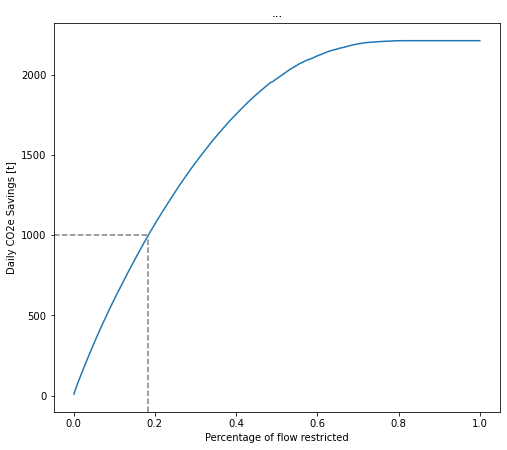

In [113]:
fig = plt.figure(figsize=(8,8))
fig.subplots_adjust(top=0.8)
ax1 = fig.add_subplot()


line, = ax1.plot(co2DF["cumulatedTotalFlow"], co2DF["cumulatedCO2eSavings"] / 1000)

ax1.set_ylabel("Daily CO2e Savings [t]")
ax1.set_xlabel("Percentage of flow restricted")
ax1.set_title('...')

relevantY = 1000 # only change this value
relevantX = np.interp(relevantY, list(co2DF["cumulatedCO2eSavings"] / 1000), list(co2DF["cumulatedTotalFlow"]))

ylim = ax1.get_ylim()
maxY = ylim[1] + abs(ylim[0])
maxPctY = (relevantY + abs(ylim[0]))/maxY

xlim = ax1.get_xlim()
maxX = xlim[1] + abs(xlim[0])
maxPctX = (relevantX + abs(xlim[0]))/maxX

plt.axvline(x=relevantX,ymax=maxPctY, linestyle="--", color="gray")
plt.axhline(y=relevantY, xmax=maxPctX, linestyle="--", color="gray")

plt.show()

In [103]:
# Most cars are around Munich, but there are no savings to be found!